In [13]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pickle
import biom
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import scipy.cluster.hierarchy as shc
from skbio.stats.composition import clr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

from src.models.MiMeNet import MiMeNet, tune_MiMeNet
from src.models.MLPNN import MLPNN

from scipy.cluster.hierarchy import cut_tree
from scipy.stats import mannwhitneyu
import tensorflow as tf

### Load Data

In [2]:
metab_df = pd.read_csv("./data/IBD/metabolome_PRISM.csv", index_col=0)
micro_df = pd.read_csv("./data/IBD/microbiome_PRISM.csv", index_col=0)

external_metab_df = pd.read_csv("./data/IBD/metabolome_external.csv", index_col=0)
external_micro_df = pd.read_csv("./data/IBD/microbiome_external.csv", index_col=0)

metabolome_meta_df = pd.read_csv("./data/IBD/metabolome_annotation.csv", index_col=0)

samples = np.intersect1d(metab_df.columns.values, micro_df.columns.values)
num_samples = len(samples)

metab_df = metab_df[samples]
micro_df = micro_df[samples]

for c in micro_df.columns:
    micro_df[c] = pd.to_numeric(micro_df[c])
    
for c in metab_df.columns:
    metab_df[c] = pd.to_numeric(metab_df[c])
    

external_samples = np.intersect1d(external_metab_df.columns.values, external_micro_df.columns.values)
external_metab_df = external_metab_df[external_samples]
external_micro_df = external_micro_df[external_samples]

for c in external_micro_df.columns:
    external_micro_df[c] = pd.to_numeric(external_micro_df[c])

for c in external_metab_df.columns:
    external_metab_df[c] = pd.to_numeric(external_metab_df[c])
        
num_external_samples = len(external_samples)   

In [3]:
dirName = 'results'
 
try:
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    
dirName = 'results/IBD'
 
try:
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")  
    
dirName = 'results/IBD/Images'
 
try:
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")  

Directory  results  already exists
Directory  results/IBD  already exists
Directory  results/IBD/Images  already exists


### Filtering of Lowly Abundant Microbes/Metabolites

In [4]:
to_drop = []

for microbe in micro_df.index.values:
    present_in = sum(micro_df.loc[microbe] > 0.0000)
    if present_in <= 0.1 * num_samples:
        to_drop.append(microbe)

micro_df = micro_df.drop(to_drop, axis=0)

to_drop = []

for metabolite in metab_df.index.values:
    present_in = sum(metab_df.loc[metabolite] > 0.0000)
    if present_in <= 0.1 * num_samples:
        to_drop.append(metabolite)

metab_df = metab_df.drop(to_drop, axis=0)

common_micro_features = np.intersect1d(micro_df.index.values, external_micro_df.index.values)
micro_df = micro_df.loc[common_micro_features]
external_micro_df = external_micro_df.loc[common_micro_features]

common_metab_features = np.intersect1d(metab_df.index.values, external_metab_df.index.values)
metab_df = metab_df.loc[common_metab_features]
external_metab_df = external_metab_df.loc[common_metab_features]
    


### Centered Log-Ratio DataFrames

In [5]:
metab_comp_df = pd.DataFrame(data=np.transpose(clr(metab_df.transpose() + 1)), 
                             index=metab_df.index, columns=metab_df.columns)

external_metab_comp_df = pd.DataFrame(data=np.transpose(clr(external_metab_df.transpose() + 1)), 
                                      index=external_metab_df.index, columns=external_metab_df.columns)
    
micro_comp_df = micro_df
external_micro_comp_df = external_micro_df

micro_comp_df = micro_comp_df.transpose()
metab_comp_df = metab_comp_df.transpose()
external_micro_comp_df = external_micro_comp_df.transpose()
external_metab_comp_df = external_metab_comp_df.transpose()


### 10-CV Prediction of Microbiome Log-Normalized Relative Abundance to Metabolome CLR

In [6]:
num_run_cv = 10
num_cv = 10
tuned = True
print("Loading network parameters...")
try:
    with open("results/IBD/network_parameters.txt", "r") as infile:
        params = json.load(infile)
        num_layer = params["num_layer"]
        layer_nodes = params["layer_nodes"]
        l1 = params["l1"]
        l2 = params["l2"]
        dropout = params["dropout"]
        learning_rate = params["learning_rate"]
        tuned = True
        print("Loaded network parameters...")
except:
    print("Warning: Could not load network parameter file!")

print("Performing %d runs of %d-fold cross-validation" % (num_run_cv, num_cv))

micro = micro_comp_df.values
metab = metab_comp_df.values

dirName = 'results/IBD/CV' 
try:
    os.mkdir(dirName)
except FileExistsError:
    pass

for run in range(0,num_run_cv):

    # Set up output directory for CV runs
    dirName = 'results/IBD/CV/' + str(run) 
    try:
        os.mkdir(dirName)
    except FileExistsError:
        pass

    # Set up CV partitions
    kfold = KFold(n_splits=num_cv, shuffle=True)
    cv = 0
        
    for train_index, test_index in kfold.split(samples):

        # Set up output directory for CV partition run
        dirName = 'results/IBD/CV/' + str(run) + '/' + str(cv)
        try:
            os.mkdir(dirName)
        except FileExistsError:
            pass
                
        # Partition data into training and test sets
        train_micro, test_micro = micro[train_index], micro[test_index]
        train_metab, test_metab = metab[train_index], metab[test_index]
        train_samples, test_samples = samples[train_index], samples[test_index]
                
        # Store training and test set partitioning
        train_microbe_df = pd.DataFrame(data=train_micro, index=train_samples, columns=micro_comp_df.columns)
        test_microbe_df = pd.DataFrame(data=test_micro, index=test_samples, columns=micro_comp_df.columns)
        train_metab_df = pd.DataFrame(data=train_metab, index=train_samples, columns=metab_comp_df.columns)
        test_metab_df = pd.DataFrame(data=test_metab, index=test_samples, columns=metab_comp_df.columns)
                
        train_microbe_df.to_csv(dirName + "/train_microbes.csv")
        test_microbe_df.to_csv(dirName + "/test_microbes.csv")
        train_metab_df.to_csv(dirName + "/train_metabolites.csv")
        test_metab_df.to_csv(dirName + "/test_metabolites.csv")
                
        # Log transform data if RA
        train_micro = np.log(train_micro + 1)
        test_micro = np.log(test_micro + 1)
                  
        # Scale data before neural network training
        micro_scaler = StandardScaler().fit(train_micro)
        train_micro = micro_scaler.transform(train_micro)
        test_micro = micro_scaler.transform(test_micro)       
                
        metab_scaler = StandardScaler().fit(train_metab)
        train_metab = metab_scaler.transform(train_metab)
        test_metab = metab_scaler.transform(test_metab)            

        # Aggregate paired microbiome and metabolomic data
        train = (train_micro, train_metab)
        test = (test_micro, test_metab)

        # Tune hyperparameters if first partition
        if tuned == False:
            print("Tuning parameters...")
            tuned = True
            num_layer, layer_nodes, l1, l2, dropout, learning_rate = tune_MiMeNet(train)
                                   
            # Save hyperparameters to file
            params = {"num_layer": num_layer, "layer_nodes": layer_nodes, "l1": l1, "l2": l2,
                        "dropout": dropout, "learning_rate": learning_rate}
            with open('results/IBD/network_parameters.txt', 'w') as outfile:
                json.dump(params, outfile)
                                            
        print("Run: %02d\t\tFold: %02d" % (run + 1, cv + 1), end="\r")
                
        # Construct Neural Network Model
        model = MiMeNet(train_micro.shape[1], train_metab.shape[1], l1=l1, l2=l2, 
                            num_layer=num_layer, layer_nodes=layer_nodes, dropout=dropout)

        #Train Neural Network Model
        model.train(train)
                
        # Predict on test set
        p = model.test(test)

        inv_p = metab_scaler.inverse_transform(p)
                
        prediction_df = pd.DataFrame(data=inv_p, index=test_samples, columns=metab_comp_df.columns)
        score_matrix_df = pd.DataFrame(data=model.get_scores(), index=micro_comp_df.columns, columns=metab_comp_df.columns)

        prediction_df.to_csv(dirName + "/prediction.csv")
        score_matrix_df.to_csv(dirName + "/score_matrix.csv")

        model.destroy()
        tf.keras.backend.clear_session()

        cv += 1
 

Loading network parameters...
Loaded network parameters...
Performing 10 runs of 10-fold cross-validation
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Get Metabolome Correlations Between Predicted and Observed


Calculating correlations for cross-validated evaluation...
Mean correlation: 0.279038


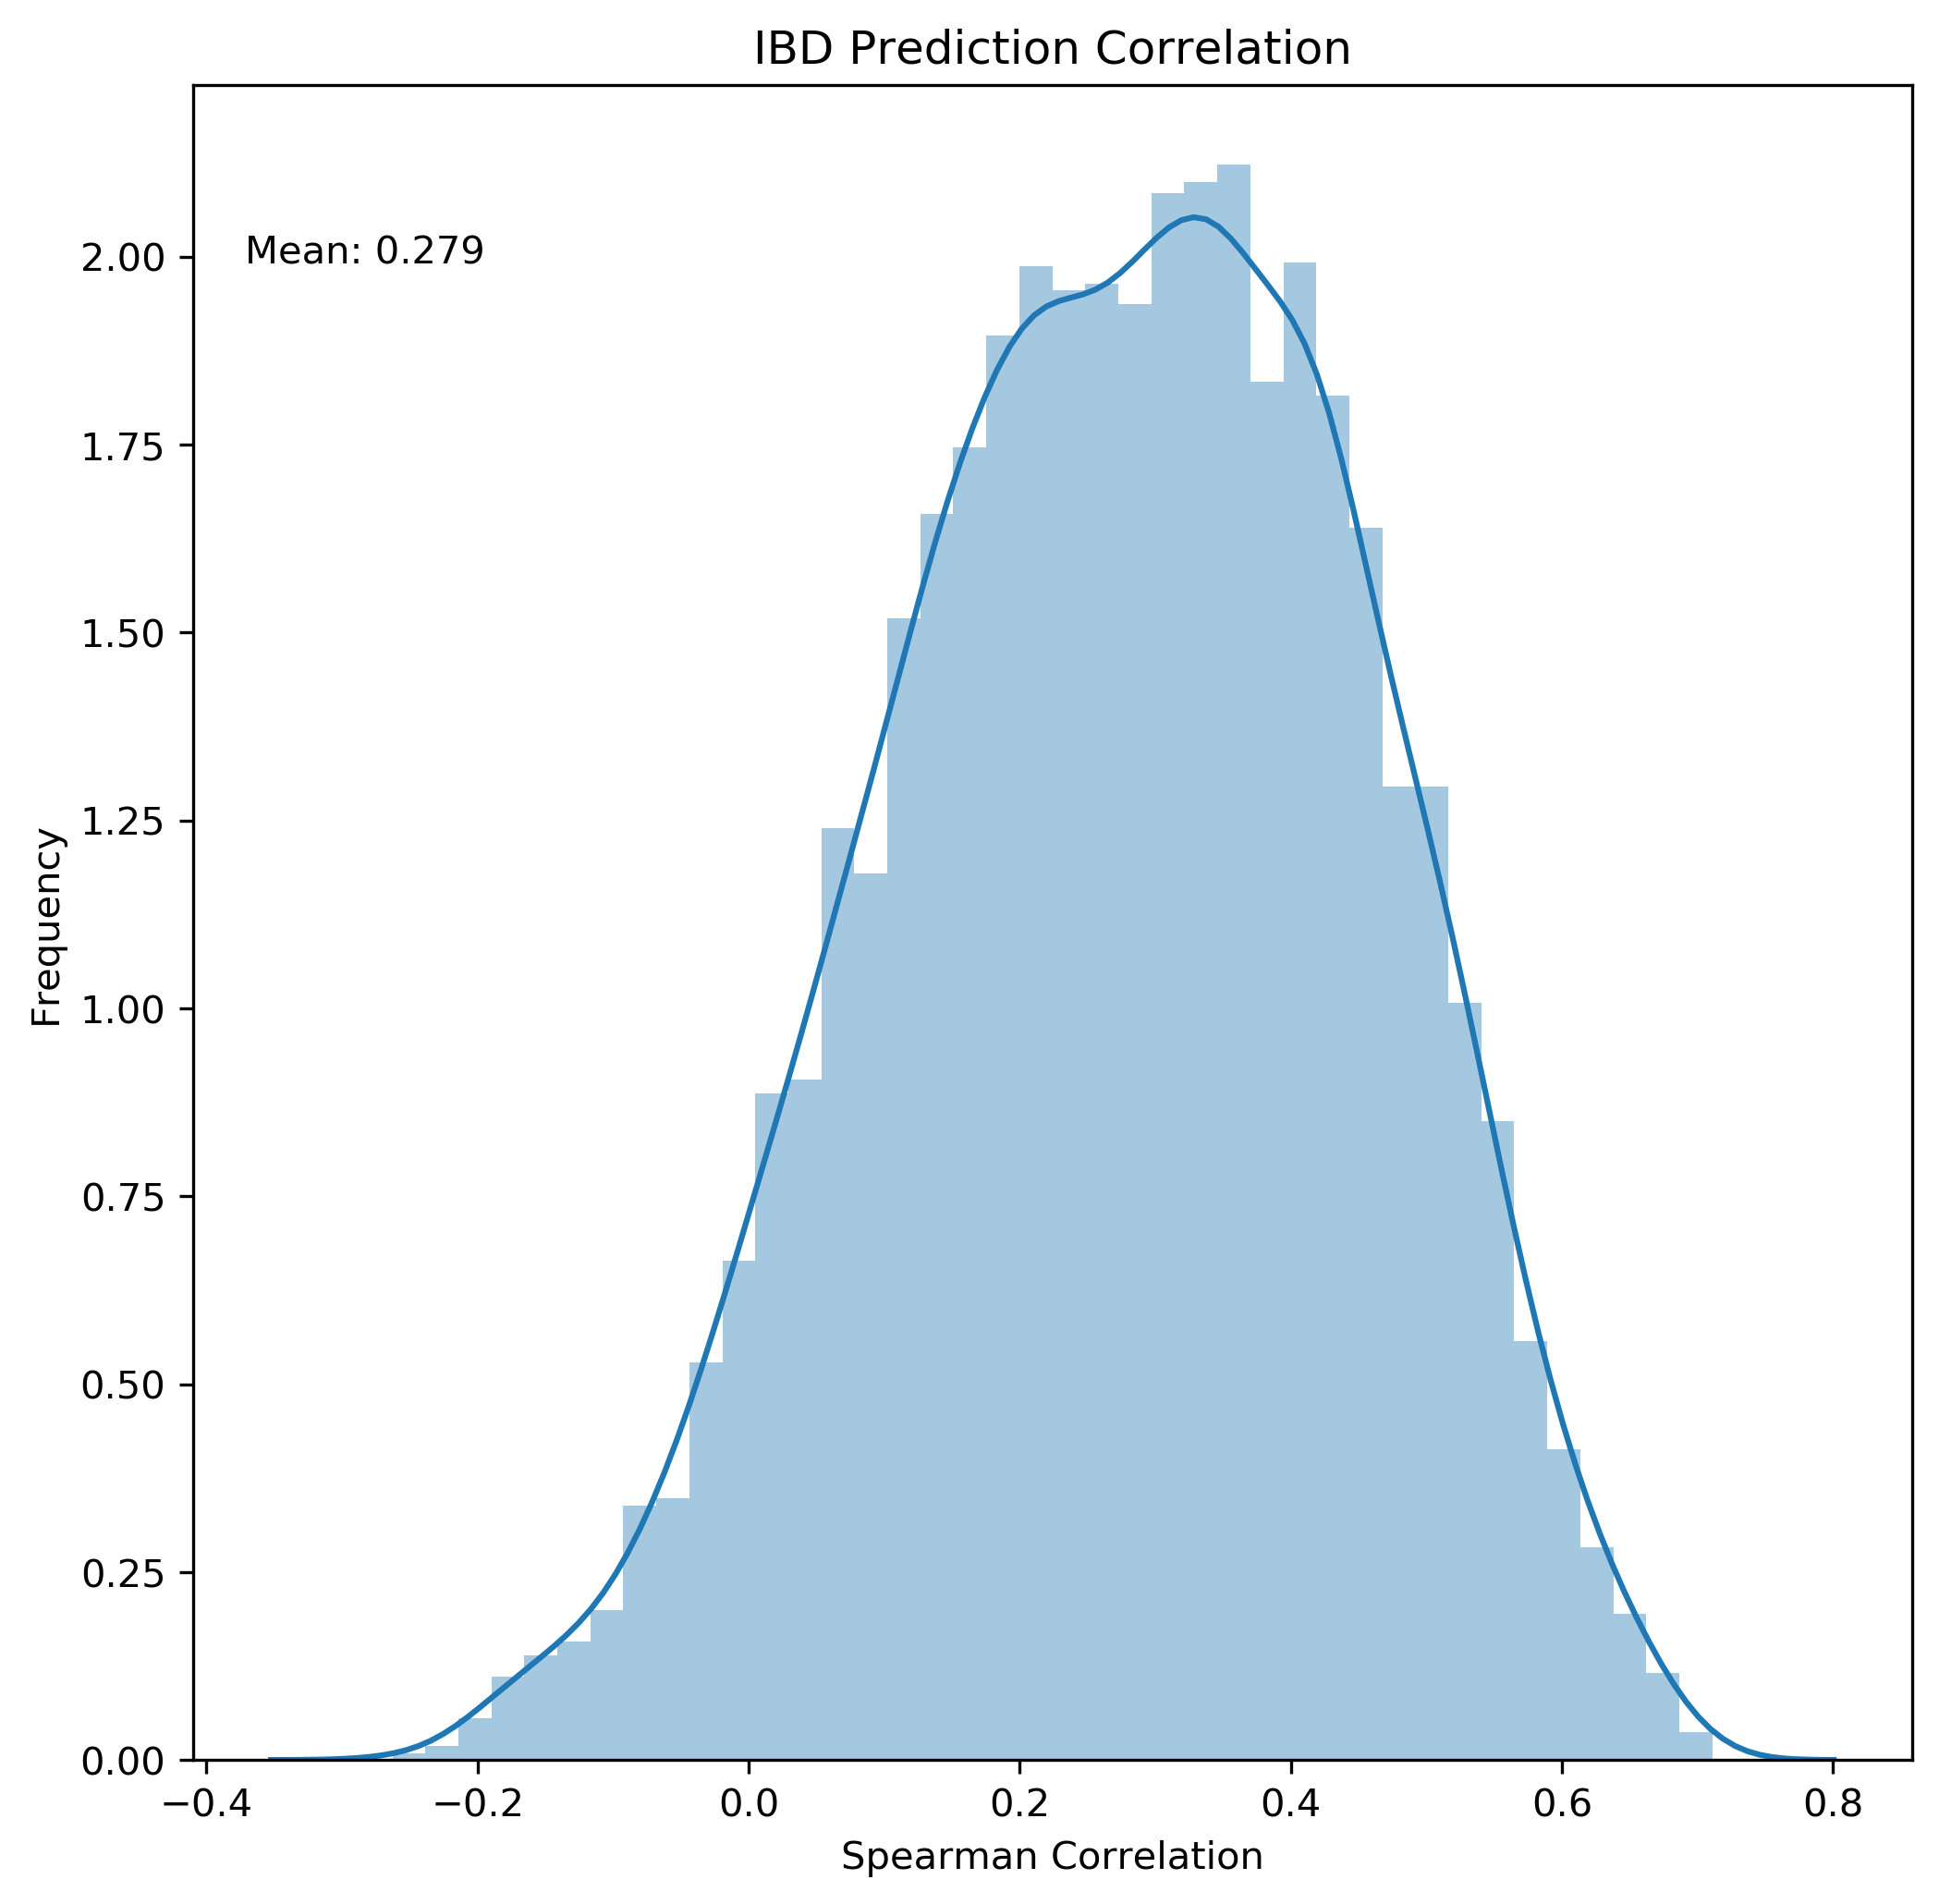

In [9]:
print("\nCalculating correlations for cross-validated evaluation...")
          
correlation_cv_df = pd.DataFrame(index=metab_comp_df.columns)

for run in range(num_run_cv):
    preds = pd.concat([pd.read_csv('results/IBD/CV/' + str(run)+ '/' + str(cv) + "/prediction.csv", 
                                    index_col=0) for cv in range(0, num_cv)])
    y = pd.concat([pd.read_csv('results/IBD/CV/' + str(run)+ '/' + str(cv) + "/test_metabolites.csv", 
                                index_col=0) for cv in range(0, num_cv)])

    cor = y.corrwith(preds, method="spearman")
    correlation_cv_df["Run_"+str(run)] = cor.loc[correlation_cv_df.index]

correlation_cv_df["Mean"] = correlation_cv_df.mean(axis=1)
correlation_cv_df = correlation_cv_df.sort_values("Mean", ascending=False)
correlation_cv_df.to_csv('results/IBD/cv_correlations.csv')

fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(111)
sns.distplot(correlation_cv_df["Mean"])
plt.title("IBD Prediction Correlation")
plt.ylabel("Frequency")
plt.xlabel("Spearman Correlation")
plt.text(0.1, 0.9,"Mean: %.3f"% np.mean(correlation_cv_df.values),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
print("Mean correlation: %f" % np.mean(correlation_cv_df.values))

    

### Generate Background

In [ ]:
print("Generating background using 100 10-fold cross-validated runs of shuffled data...")
bg_preds = []
bg_truth = []
bg_scores = []

for run in range(0,100):
    preds = []
    truth = []
    score_matrix = []

    micro = micro_comp_df.values
    metab = metab_comp_df.values

    np.random.shuffle(micro)
    np.random.shuffle(metab)

    kfold = KFold(n_splits=10)
    cv=0
    for train_index, test_index in kfold.split(micro):
        print("Run: %02d\t\tFold:%02d" % (run + 1, cv + 1), end="\r")
        train_micro, test_micro  = micro[train_index], micro[test_index]
        train_metab, test_metab = metab[train_index], metab[test_index]

        # Scale data before neural network training
        micro_scaler = StandardScaler().fit(train_micro)
        train_micro = micro_scaler.transform(train_micro)
        test_micro = micro_scaler.transform(test_micro)       

        metab_scaler = StandardScaler().fit(train_metab)
        train_metab = metab_scaler.transform(train_metab)
        test_metab = metab_scaler.transform(test_metab)        

        train = (train_micro, train_metab)
        test = (test_micro, test_metab)

        model = MiMeNet(train_micro.shape[1], train_metab.shape[1], l1=l1, l2=l2, 
                            num_layer=num_layer, layer_nodes=layer_nodes, dropout=dropout)

        model.train(train)
        p = model.test(test)

        preds = list(preds) + list(p)
        truth = list(truth) + list(test_metab)
        score_matrix.append(model.get_scores())

        model.destroy()
        tf.keras.backend.clear_session()
        cv+=1

    bg_preds.append(preds)
    bg_truth.append(truth)
    bg_scores.append(score_matrix)

print("\nFinished generating background...")

### Save Background

In [61]:
print("Saving background...")

dirName = 'results/IBD/BG/'
try:
    os.mkdir(dirName)
except FileExistsError:
    pass

bg_preds = np.array(bg_preds)
bg_truth = np.array(bg_truth)
bg_scores = np.array(bg_scores)
bg_scores_mean = np.mean(np.array(bg_scores), axis=1)
    
outfile = open(dirName + "bg_preds.pkl", "wb")
pickle.dump(np.array(bg_preds), outfile)
outfile.close()

outfile = open(dirName + "bg_truth.pkl", "wb")
pickle.dump(np.array(bg_truth), outfile)
outfile.close()

outfile = open(dirName + "bg_scores_mean.pkl", "wb")
pickle.dump(bg_scores_mean, outfile)
outfile.close() 

bg_corr = []

for i in range(0, bg_preds.shape[0]):
    for j in range(0,bg_preds.shape[-1]):
        p_vec = bg_preds[i,:,j]
        m_vec = bg_truth[i,:,j]
        cor = spearmanr(p_vec, m_vec)
        bg_corr.append(cor[0])

outfile = open(dirName + "bg_correlations.pkl", "wb")
pickle.dump(np.array(bg_corr), outfile)
outfile.close()


Saving background...


### Load Background if Previously Generated

In [7]:
try:
    print("Loading background from directory...")
    infile = open("results/IBD/BG/bg_preds.pkl", "rb")
    bg_preds = pickle.load(infile)
    infile.close()

    infile = open("results/IBD/BG/bg_truth.pkl", "rb")
    bg_truth = pickle.load(infile)
    infile.close()

    infile = open("results/IBD/BG/bg_scores_mean.pkl", "rb")
    bg_scores_mean = pickle.load(infile)
    infile.close()
        
    infile = open("results/IBD/BG/bg_correlations.pkl", "rb")
    bg_corr = pickle.load(infile)
    infile.close()
except:
    print("Warning: Failed to load background from directory...")


Loading background from directory...


### Get Top Predicted Metabolties

The correlation cutoff is 0.141
6857 of 8847 metabolites are significantly correlated
351 of 466 annotated metabolites are significantly correlated


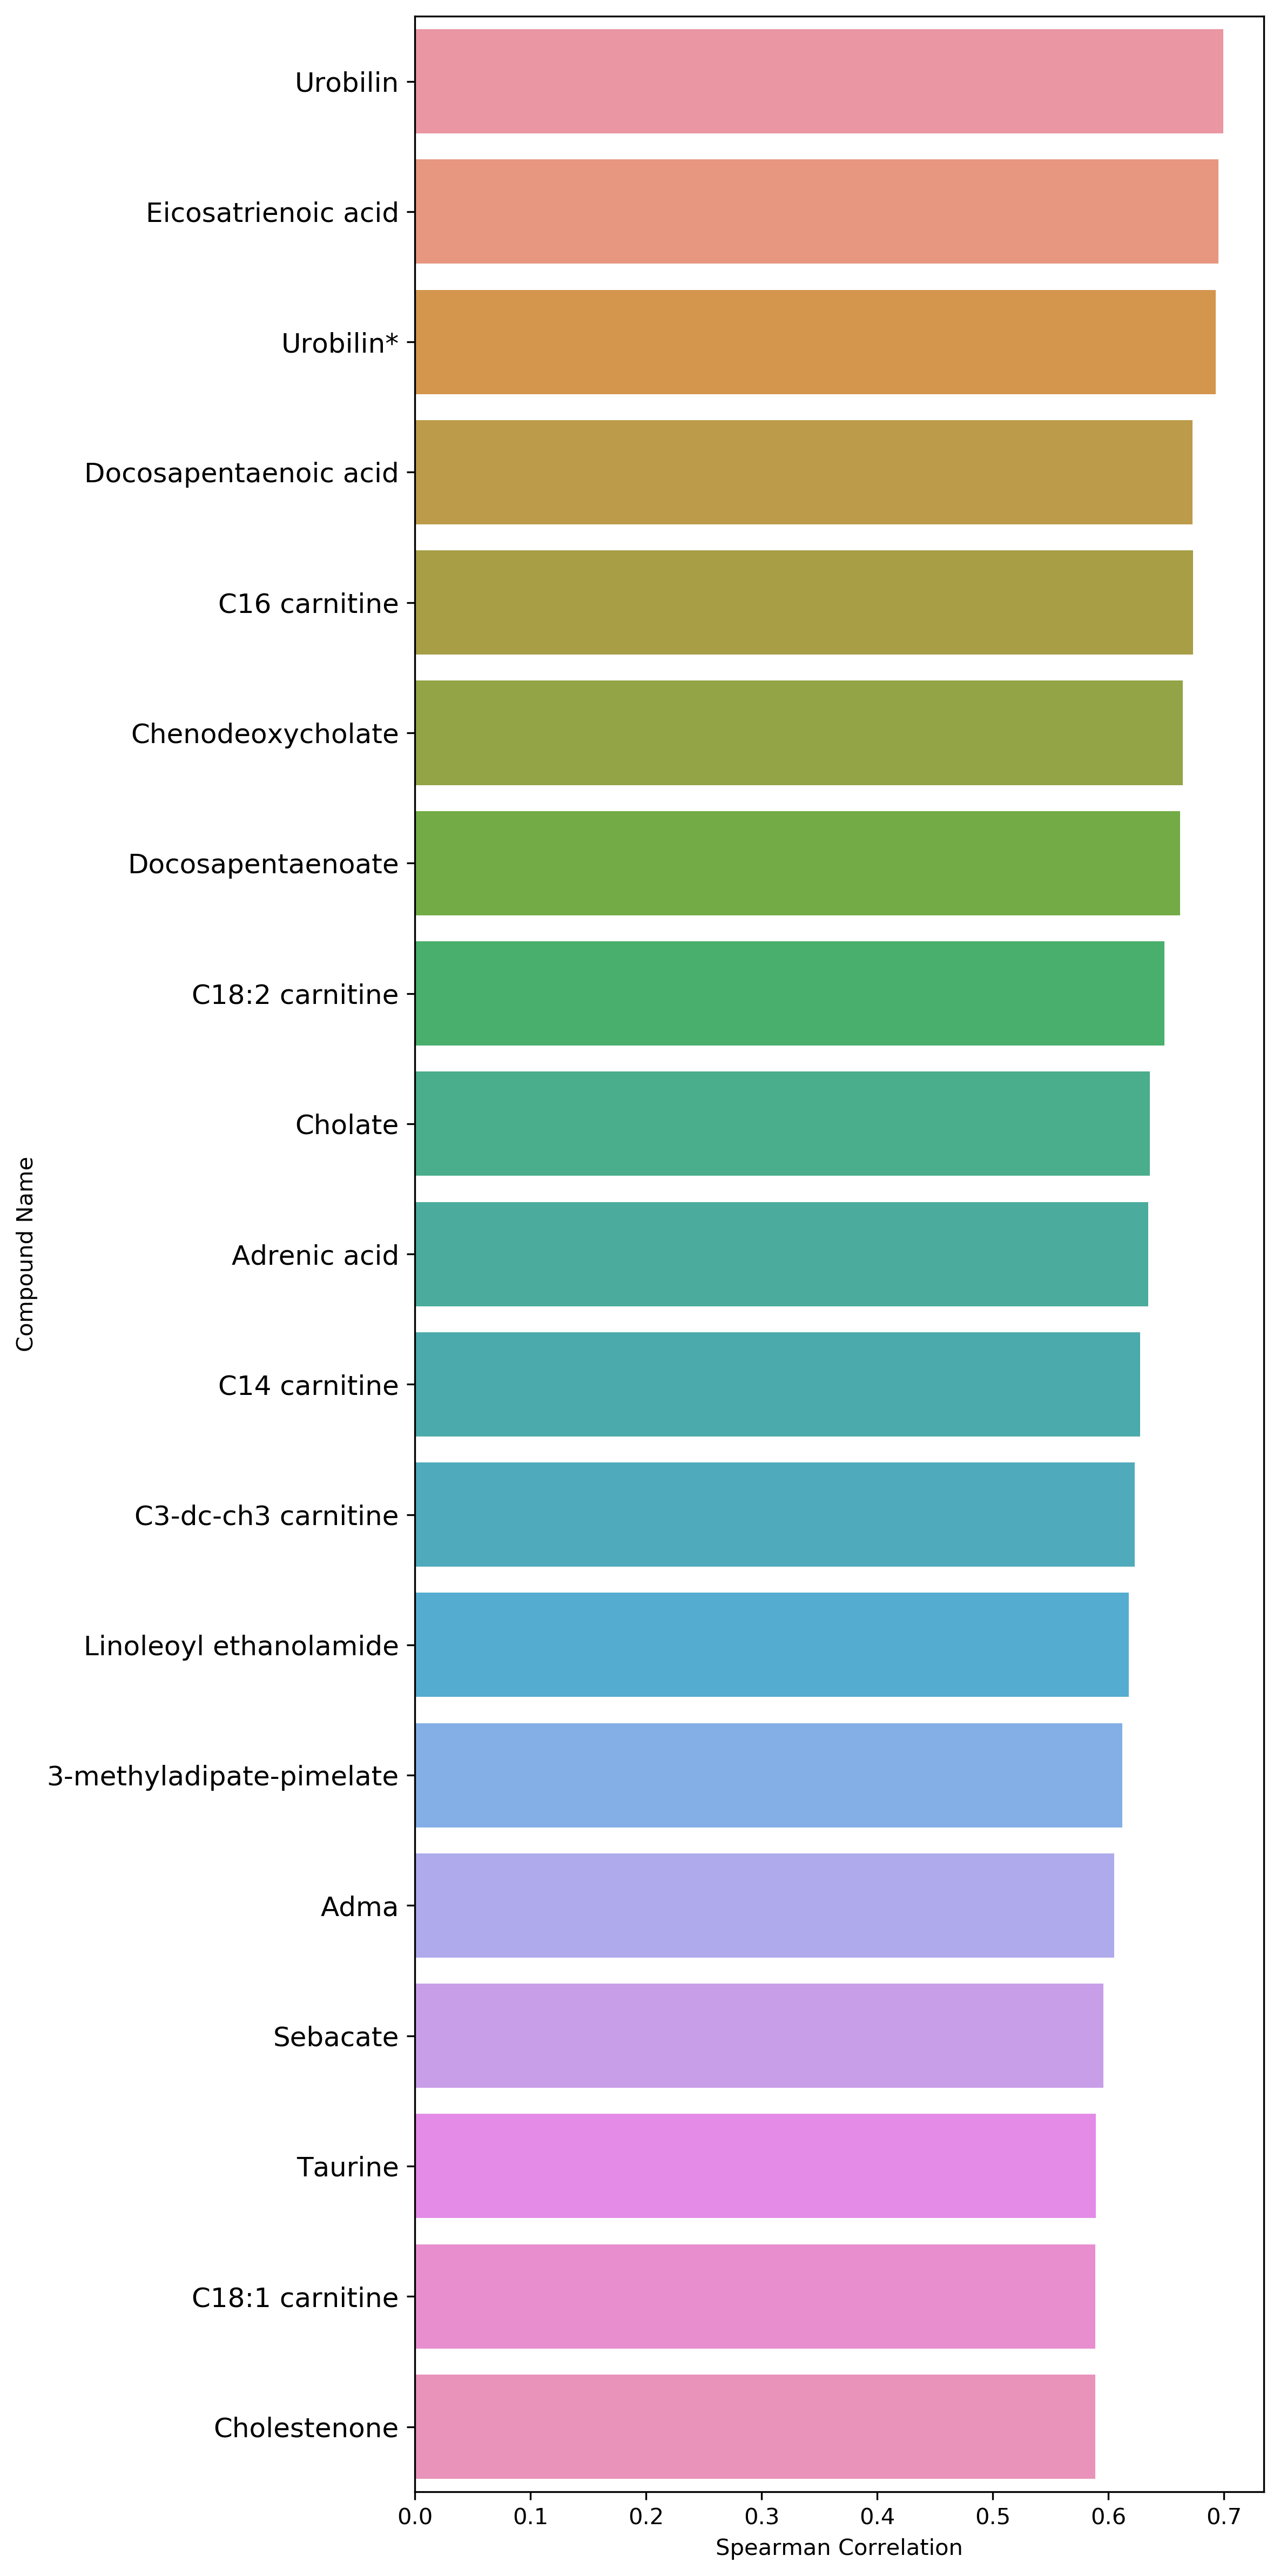

In [12]:
cutoff_rho = np.quantile(bg_corr, 0.95)
print("The correlation cutoff is %.3f" % cutoff_rho)
print("%d of %d metabolites are significantly correlated" % (sum(correlation_cv_df["Mean"].values > cutoff_rho),
                                                             len(correlation_cv_df["Mean"].values)))

sig_metabolites = correlation_cv_df.index[correlation_cv_df["Mean"].values > cutoff_rho]

annotated_metabolites = np.intersect1d(correlation_cv_df.index.values, metabolome_meta_df.index.values)
sig_metabolites_annotated = annotated_metabolites[correlation_cv_df.loc[annotated_metabolites, "Mean"].values > cutoff_rho]
    
print("%d of %d annotated metabolites are significantly correlated" % (len(sig_metabolites_annotated), len(annotated_metabolites)))

# We change the fontsize of minor ticks label     
barplot_df = pd.DataFrame(data={"Compound Name":metabolome_meta_df.loc[sig_metabolites_annotated, "Compound Name"].values, 
                                "Spearman Correlation": correlation_cv_df.loc[sig_metabolites_annotated, "Mean"].values}, 
                              index=metabolome_meta_df.loc[sig_metabolites_annotated, "Compound Name"].values)

barplot_df["Compound Name"] = [x.strip().capitalize() for x in barplot_df["Compound Name"].values]
# We change the fontsize of minor ticks label 
    
fig = plt.figure(figsize=(8,16), dpi=300)
ax = fig.add_subplot(111)
sns.barplot(x="Spearman Correlation", y='Compound Name', ci=None,
            data=barplot_df.groupby(barplot_df.index).max().sort_values(by="Spearman Correlation", ascending=False).head(20))
ax.tick_params(axis='y', which='major', labelsize=12)
plt.xlabel("Spearman Correlation", fontsize=10)
plt.tight_layout()

### Compare Background to Observed Distribution

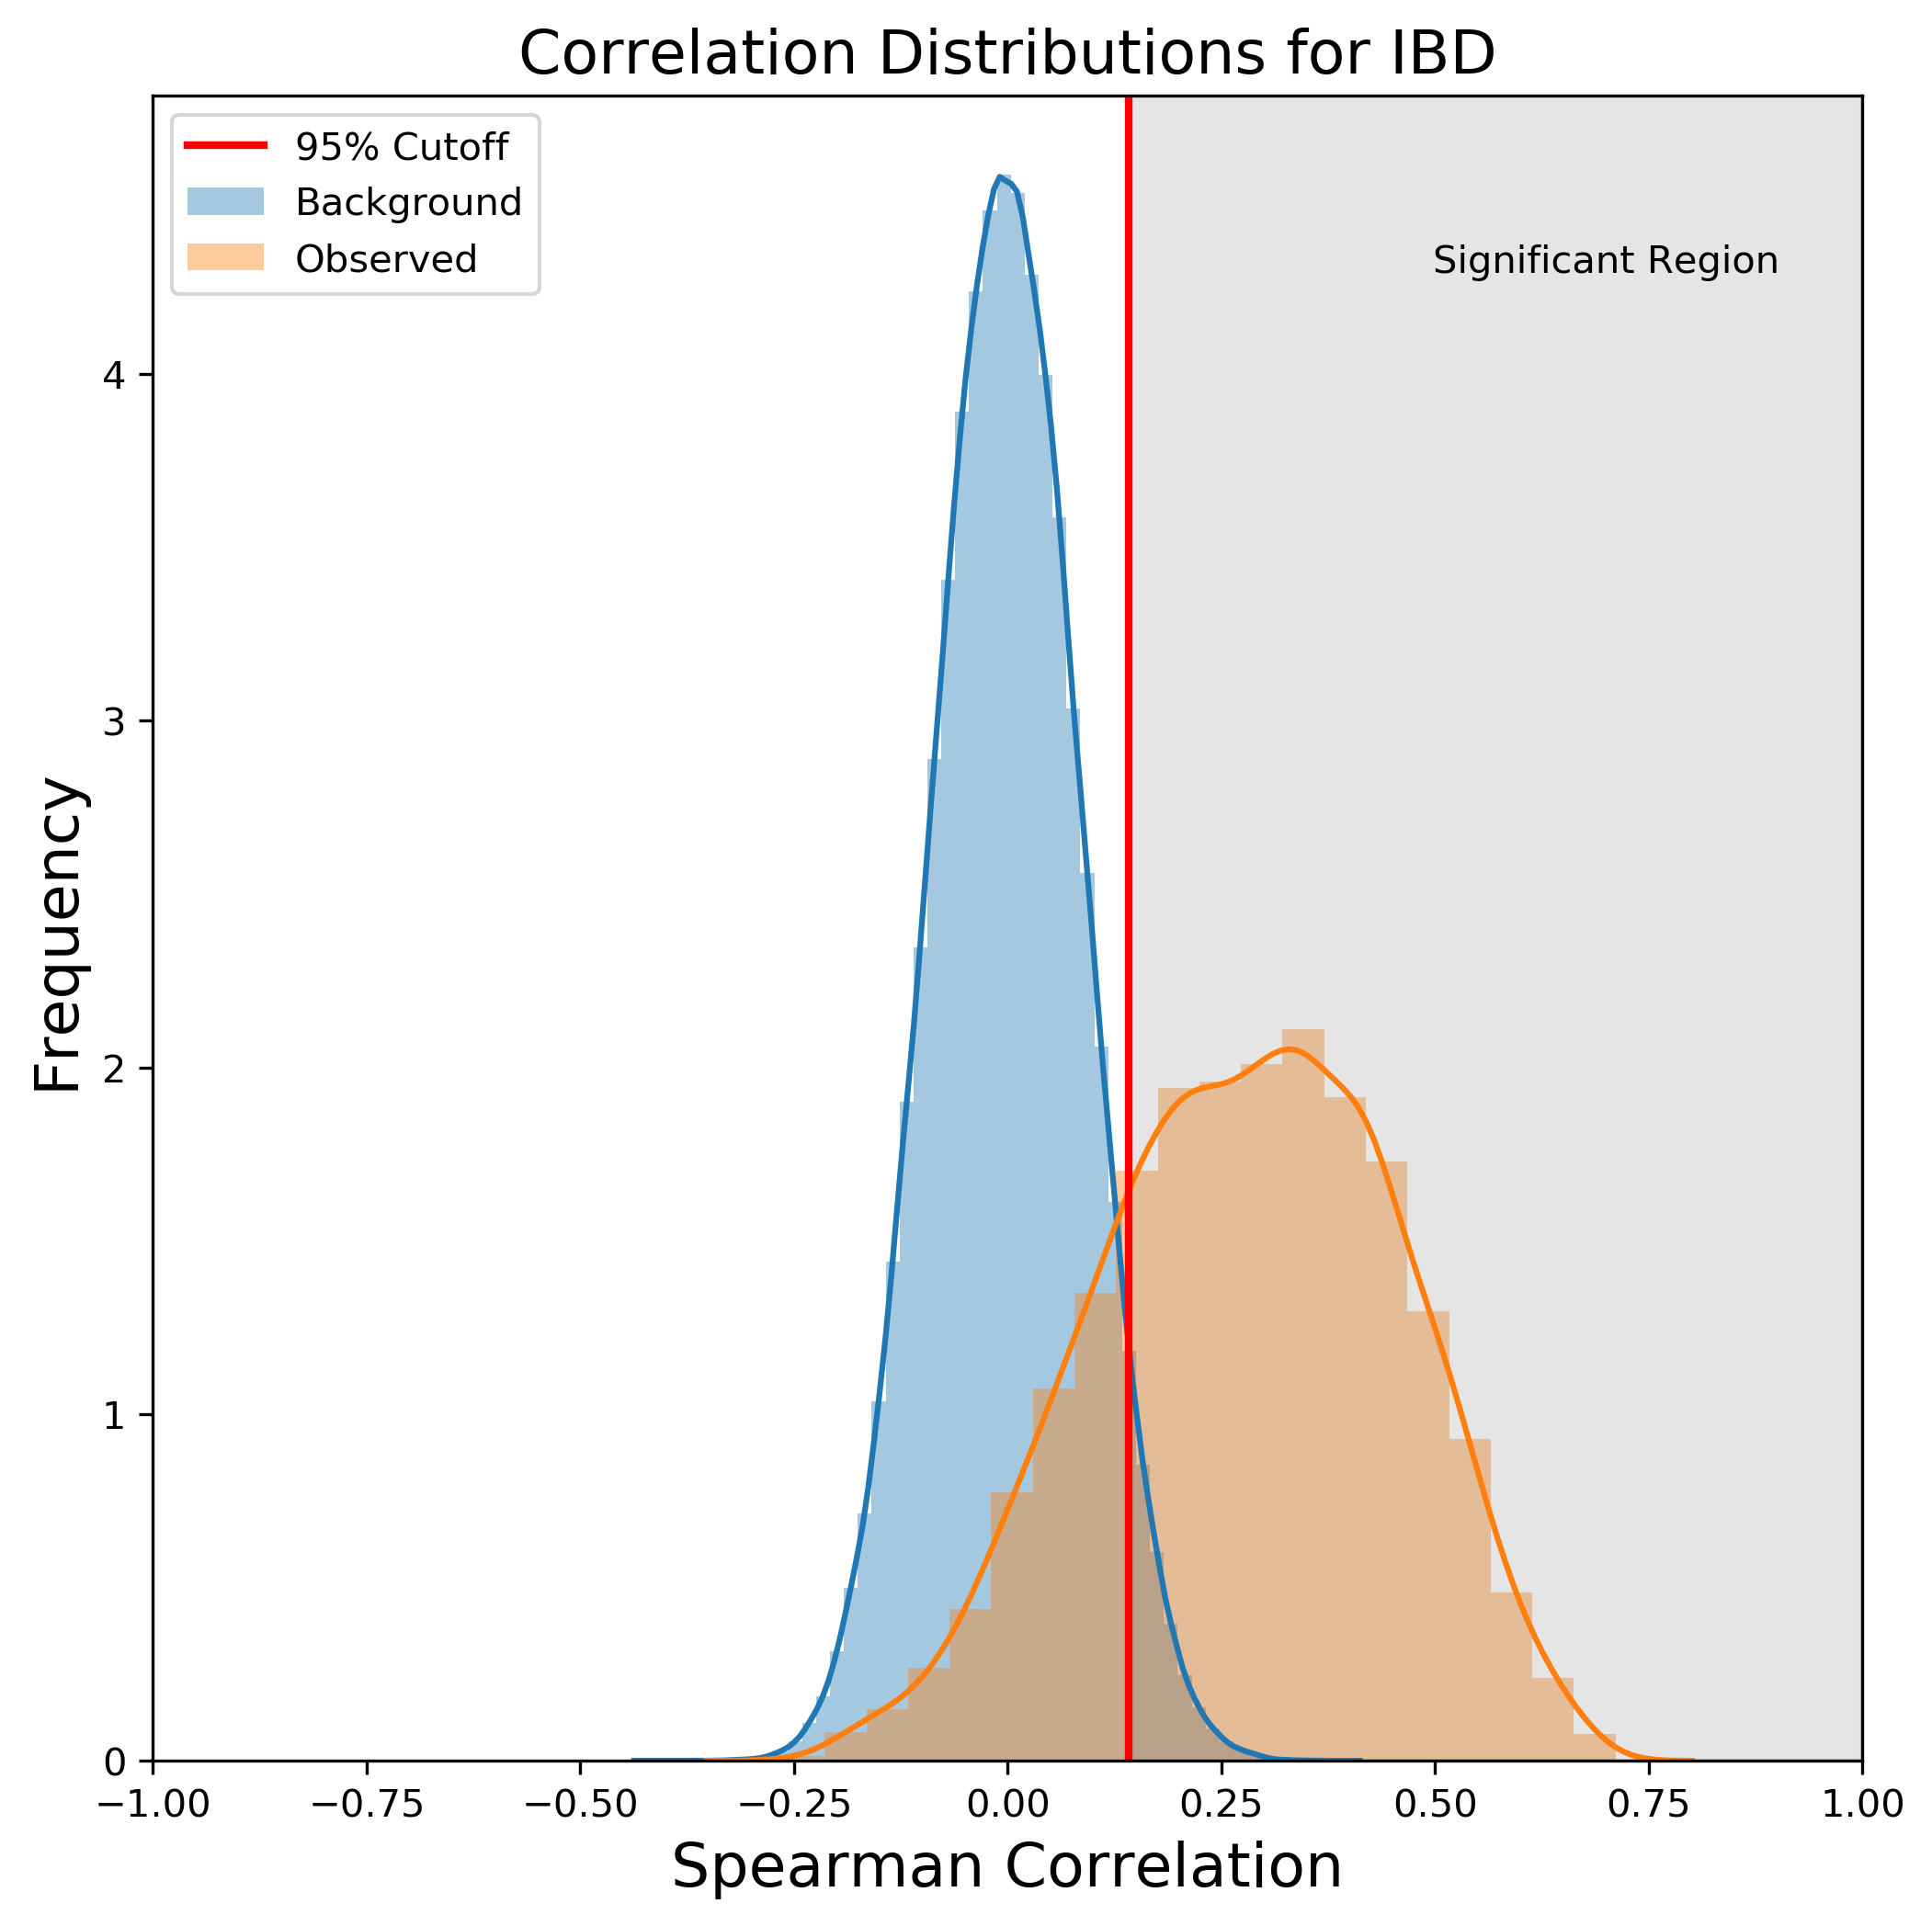

In [11]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(111)
sns.distplot(bg_corr, label="Background")
sns.distplot(correlation_cv_df["Mean"].values, bins=20, label="Observed")
plt.axvline(x=cutoff_rho, color="red", lw=2, label="95% Cutoff")
plt.axvspan(cutoff_rho, 1.0, alpha=0.2, color='gray')

plt.title("Correlation Distributions for IBD", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Spearman Correlation", fontsize=16)
plt.xlim(-1,1)
plt.text(0.85, 0.9,"Significant Region",
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
plt.legend()


In [10]:
print("Identifying microbes with significant interactions...")
score_list = []
for run in range(num_run_cv):
    for cv in range(num_cv):
        score_df = pd.read_csv("results/IBD/CV/" + str(run) + "/" + str(cv) + "/score_matrix.csv", index_col=0, header=0)
        score_list.append(score_df.values)

mean_score_matrix = np.mean(np.array(score_list), axis=0)

reduced_mean_score_matrix = mean_score_matrix[:,[x in sig_metabolites for x in correlation_cv_df.index]]
reduced_bg_score_matrix = bg_scores_mean[:,:,[x in sig_metabolites for x in correlation_cv_df.index]]

sig_edge_matrix = np.zeros(reduced_mean_score_matrix.shape)

for mic in range(reduced_mean_score_matrix.shape[0]):
    for met in range(reduced_mean_score_matrix.shape[1]):
        sig_cutoff = np.abs(np.quantile(reduced_bg_score_matrix[:,mic,met], 0.975))
        if np.abs(reduced_mean_score_matrix[mic,met]) > sig_cutoff:
            sig_edge_matrix[mic,met]=1

            
sig_microbes = micro_comp_df.columns[np.sum(sig_edge_matrix, axis=1)> 0.01 * len(sig_metabolites)]

Identifying microbes with significant interactions...


### Determine Number of Microbial and Metabolic Clusters

In [ ]:
score_list = []
for run in range(num_run_cv):
    for cv in range(num_cv):
        score_df = pd.read_csv("results/IBD/CV/" + str(run) + "/" + str(cv) + "/score_matrix.csv", index_col=0, header=0)
        score_list.append(score_df.loc[sig_microbes, sig_metabolites].values)
    

In [645]:
import scipy.cluster.hierarchy as shc
import itertools

mic_linkage_list = []
c = 0

for s in score_list:
    mic_linkage_list.append(shc.linkage(np.clip(s/sig_cutoff, -1, 1), method='complete'))

mic_connectivity_matrices = {}
for i in range(2,20):
    mic_connectivity_matrices[i] = []
    for l in range(len(linkage_list)):
        microbe_clusters = np.array(cut_tree(mic_linkage_list[l], n_clusters=i)).reshape(-1)
        one_hot_matrix = np.zeros((len(sig_microbes), i))
        for m in range(len(microbe_clusters)):
            one_hot_matrix[m, microbe_clusters[m]] = 1
        mic_connectivity_matrix = np.matmul(one_hot_matrix, np.transpose(one_hot_matrix)) 
        mic_connectivity_matrices[i].append(mic_connectivity_matrix)
        

In [ ]:

fig = plt.figure(figsize=(16,8), dpi=300)
plt.subplot(1,2,1)
area_x = []
area_y = []
for i in range(2,20):
    consensus_matrix = np.mean(mic_connectivity_matrices[i], axis=0)
    n = consensus_matrix.shape[0]
    consensus_cdf_x = []
    consensus_cdf_y = []
    area_x.append(int(i))

    
plt.xlabel("Consensus Index Value")
plt.ylabel("CDF")
plt.legend()

dk = []
for a in range(len(area_x)):
    if area_x[a] == 2:
        dk.append(area_y[a])
    else:
        dk.append((area_y[a] - area_y[a-1])/area_y[a-1])
        
plt.subplot(1,2,2)
plt.plot(area_x, dk, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Relative Increase of Area under CDF")
plt.axhline(0.02, linewidth=2, color='r')

num_microbiome_clusters = np.max(np.array(area_x)[np.array(dk) > 0.02])
print("Using %d Microbiome Clusters" % num_microbiome_clusters)

In [ ]:
import scipy.cluster.hierarchy as shc
import itertools


met_connectivity_matrices = {}
c = 0
for i in range(2,20):
    met_connectivity_matrices[i] = np.zeros((len(sig_metabolites), len(sig_metabolites)))

count = 0
for s in score_list:
    print(count)
    count += 1
    met_linkage_list = shc.linkage(np.transpose(np.clip(s/sig_cutoff, -1,1)), method='complete')

    for i in range(2,20):
        metabolite_clusters = np.array(cut_tree(met_linkage_list, n_clusters=i)).reshape(-1)
        one_hot_matrix = np.zeros((len(sig_metabolites), i))
        for m in range(len(metabolite_clusters)):
            one_hot_matrix[m, metabolite_clusters[m]] = 1
        met_connectivity_matrix = np.matmul(one_hot_matrix, np.transpose(one_hot_matrix)) 
        met_connectivity_matrices[i] += met_connectivity_matrix

Using 8 Metabolite Clusters


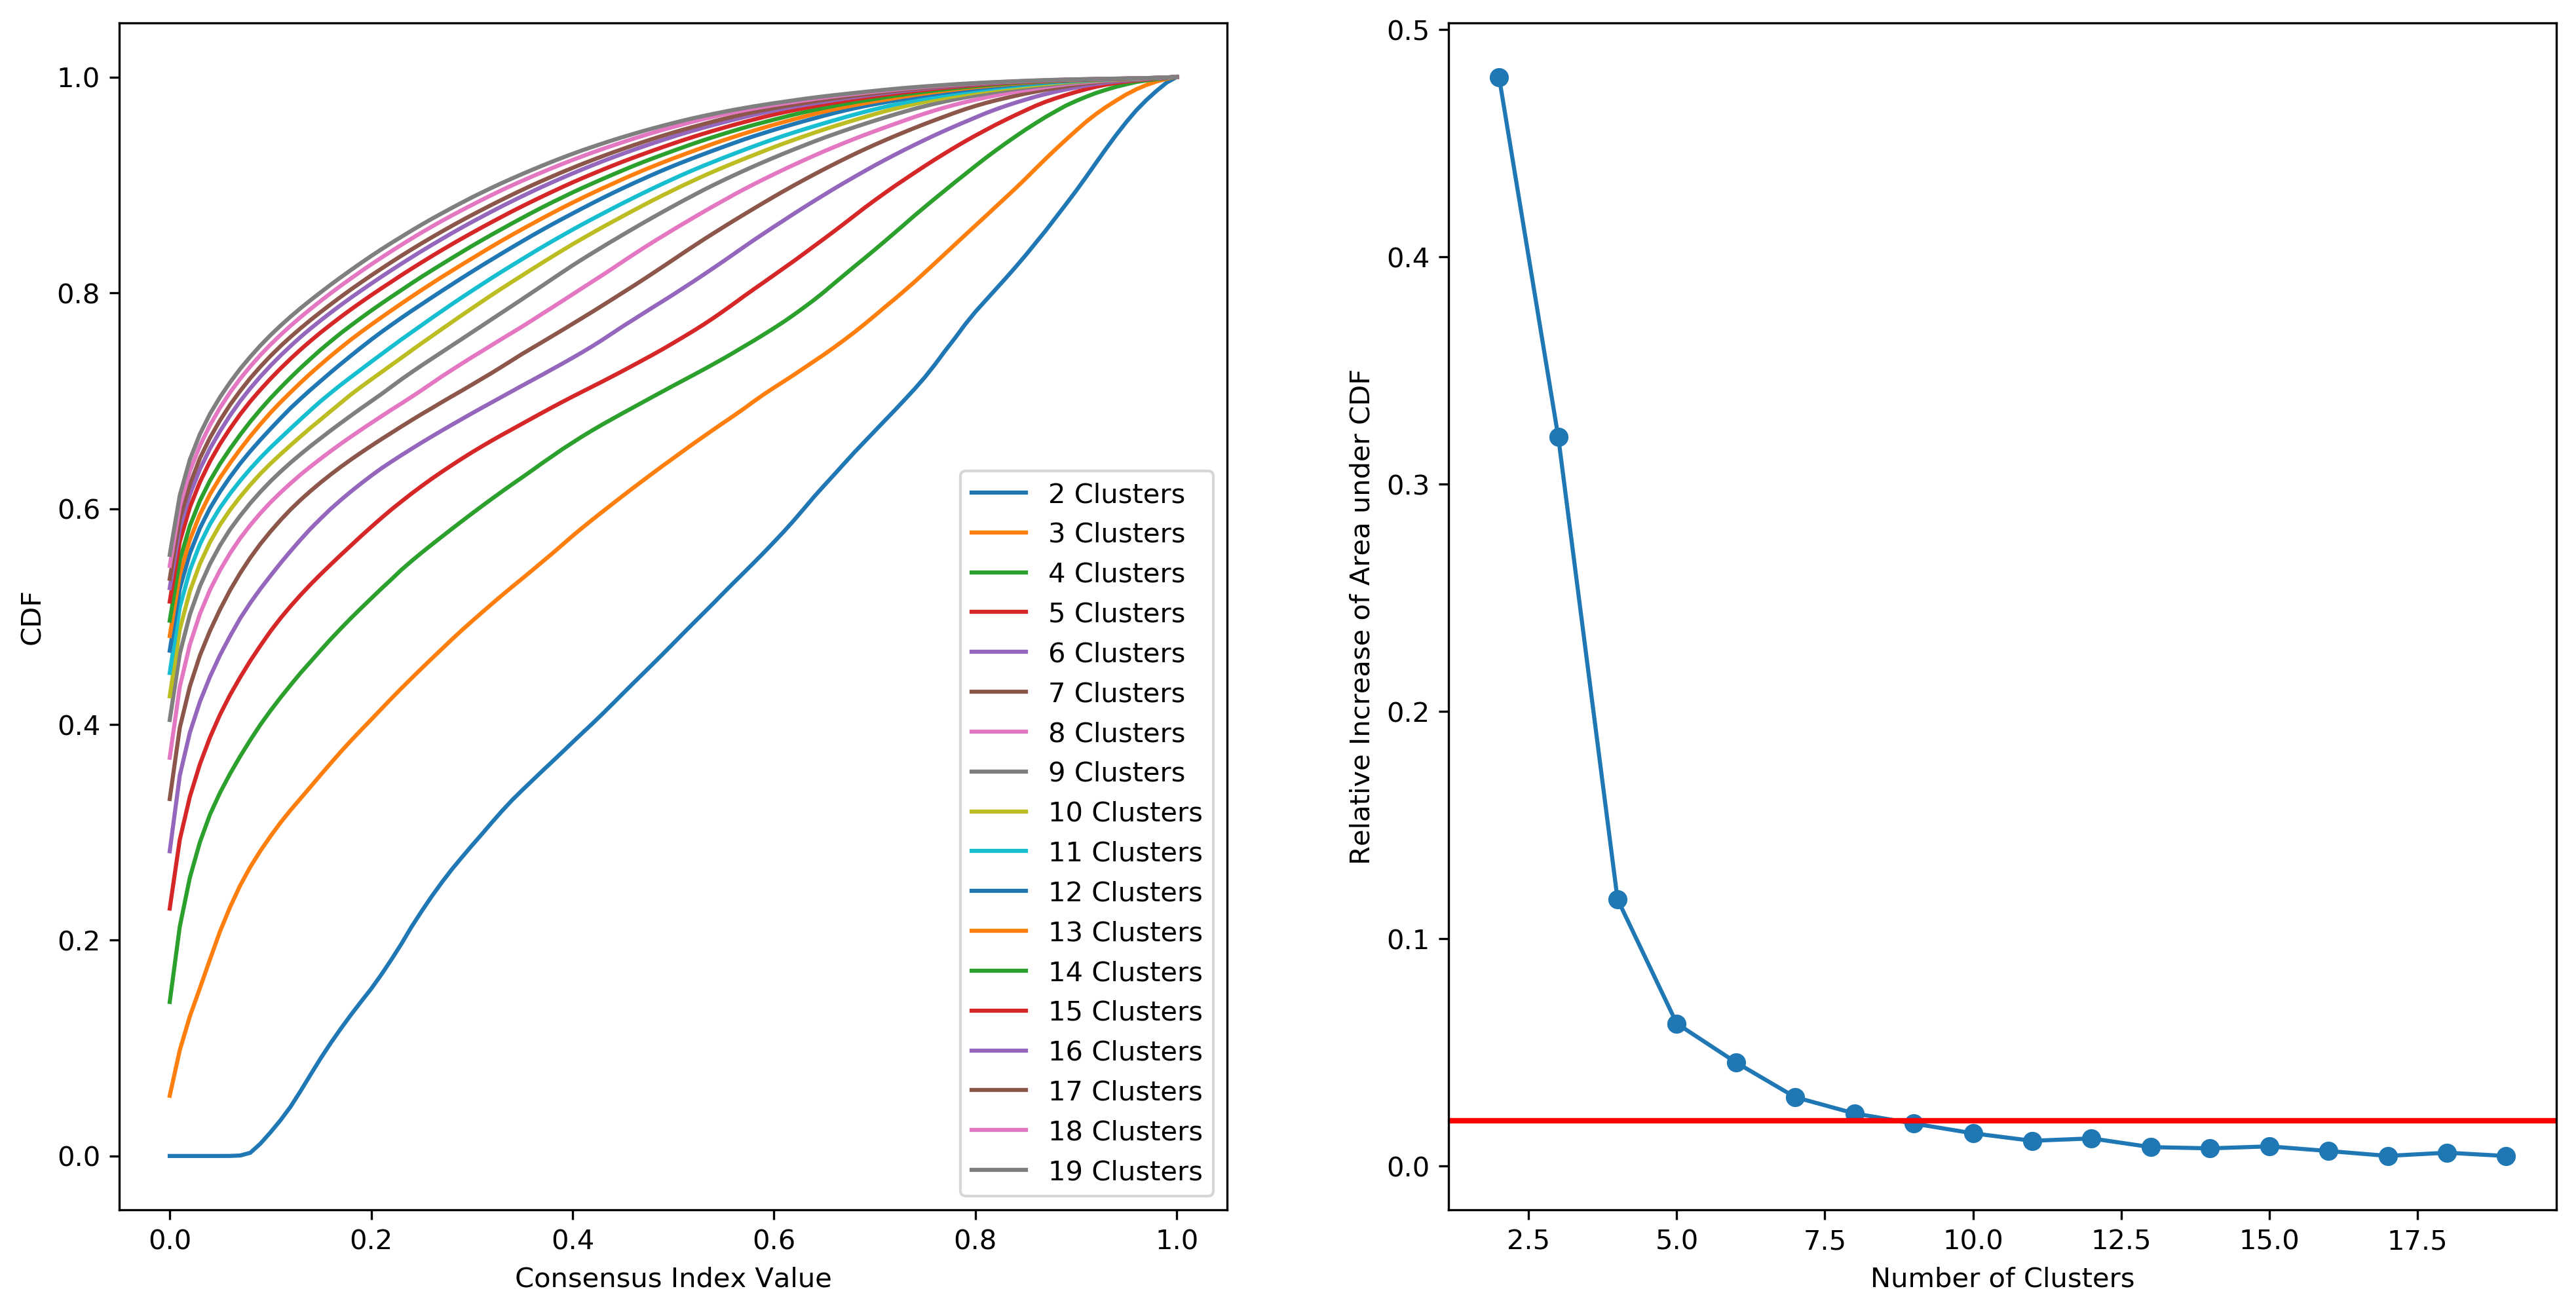

In [806]:
fig = plt.figure(figsize=(16,8), dpi=300)
plt.subplot(1,2,1)
area_x = []
area_y = []
for i in range(2,20):
    consensus_matrix = met_connectivity_matrices[i]/(num_run_cv * num_run)
    n = consensus_matrix.shape[0]
    consensus_cdf_x = []
    consensus_cdf_y = []
    area_x.append(int(i))
    
    prev_y = 0
    prev_x = 0
    area = 0
    for j in range(0,101):
        x = float(j)/100.0
        y = sum(sum(consensus_matrix <= x))/(n*(n-1))
        consensus_cdf_x.append(x)
        consensus_cdf_y.append(y)
        area += (x-prev_x) * (y)
        prev_x = x
    area_y.append(area)
    
    plt.plot(consensus_cdf_x, consensus_cdf_y, label=str(i) + " Clusters")
plt.xlabel("Consensus Index Value")
plt.ylabel("CDF")
plt.legend()

dk = []
for a in range(len(area_x)):
    if area_x[a] == 2:
        dk.append(area_y[a])
    else:
        dk.append((area_y[a] - area_y[a-1])/area_y[a-1])
        
plt.subplot(1,2,2)
plt.plot(area_x, dk, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Relative Increase of Area under CDF")
plt.axhline(0.02, linewidth=2, color='r')

num_metabolite_clusters = np.max(np.array(area_x)[np.array(dk) > 0.02])
print("Using %d Metabolite Clusters" % num_metabolite_clusters)

### Bicluster Score Matrix

Biclustering filtered interaction matrix...


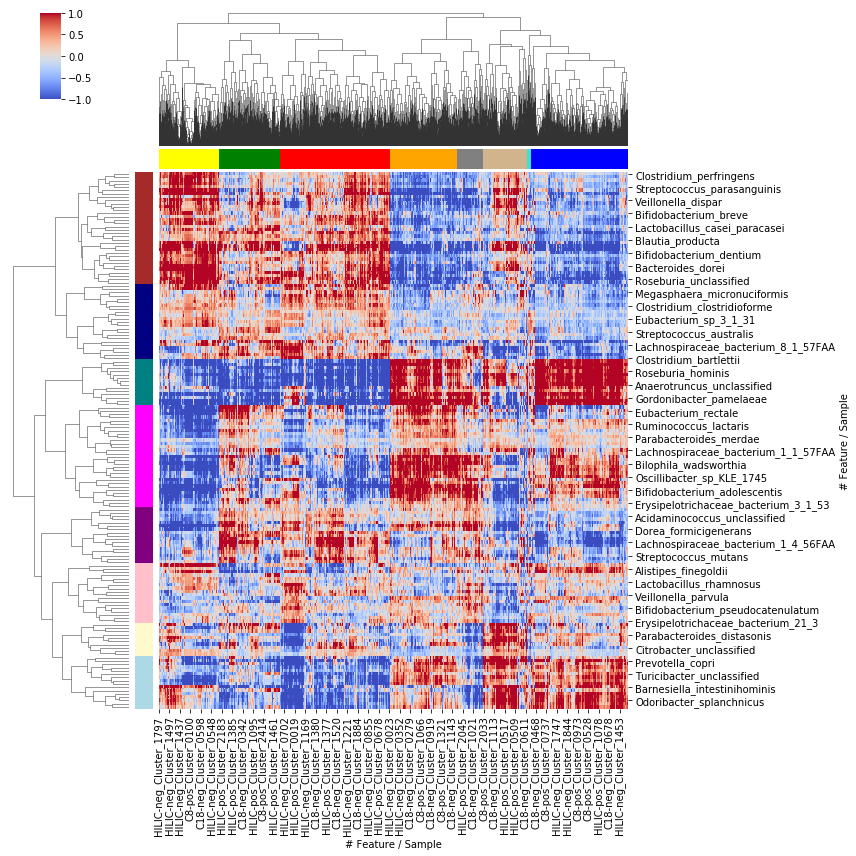

In [748]:
print("Biclustering filtered interaction matrix...")
score_matrix_df = pd.DataFrame(mean_score_matrix, index=micro_comp_df.columns, 
                            columns=metab_comp_df.columns)
        
reduced_score_df = score_matrix_df.loc[sig_microbes, sig_metabolites]

binary_score_df = pd.DataFrame(np.clip(reduced_score_df/sig_cutoff, -1, 1), index=sig_microbes,
                               columns= sig_metabolites)


microbe_tree = shc.linkage(binary_score_df.values, method='complete')
metabolite_tree = shc.linkage(np.transpose(binary_score_df.values), method='complete')

metabolite_clusters = np.array(cut_tree(metabolite_tree, n_clusters=num_metabolite_clusters)).reshape(-1)
microbe_clusters = np.array(cut_tree(microbe_tree, n_clusters=num_microbiome_clusters)).reshape(-1)

metab_color_list = ["red", "blue", "orange", "yellow", "green", "tan", "gray", "turquoise", "lightsteelblue", "chocolate", "khaki", "lime", "lightgreen", "red"]
microbe_color_list = ["purple", "teal", "pink", "lightblue", "brown", "magenta", "lemonchiffon", "navy", "palegreen", "darkorange", "salmon", "black"]

microbe_colors = [microbe_color_list[x] for x in microbe_clusters]
metabolite_colors = [metab_color_list[x] for x in metabolite_clusters]

sns.clustermap(binary_score_df, row_linkage=microbe_tree, col_linkage=metabolite_tree,
               method="complete", row_colors = microbe_colors, col_colors=metabolite_colors, 
               cmap = "coolwarm", figsize=(12,12), cbar_pos=(0.05, 0.88, 0.025, 0.10))
plt.savefig("results/IBD/Images/clustermap.png", dpi=300)
        
reduced_score_df.to_csv("results/IBD/CV/filtered_interaction_score_matrix.csv")

micro_cluster_matrix = np.zeros((reduced_score_df.values.shape[0], reduced_score_df.values.shape[0]))
metab_cluster_matrix = np.zeros((reduced_score_df.values.shape[1], reduced_score_df.values.shape[1]))
        
for m in range(0, len(microbe_clusters)):
    for n in range(m, len(microbe_clusters)):
        if microbe_clusters[m] == microbe_clusters[n]:
            micro_cluster_matrix[m,n] = 1
            micro_cluster_matrix[n,m] = 1

for m in range(0, len(metabolite_clusters)):
    for n in range(m, len(metabolite_clusters)):
        if metabolite_clusters[m] == metabolite_clusters[n]:
            metab_cluster_matrix[m,n] = 1
            metab_cluster_matrix[n,m] = 1
                    
pd.DataFrame(data=micro_cluster_matrix, index=reduced_score_df.index, 
                     columns=reduced_score_df.index).to_csv("results/IBD/CV/microbe_cluster_matrix.csv")   

pd.DataFrame(data=metab_cluster_matrix, index=reduced_score_df.columns, 
                     columns=reduced_score_df.columns).to_csv("results/IBD/CV/metabolite_cluster_matrix.csv")  



In [756]:
metabolite_cluster_df = pd.DataFrame(data=metabolite_clusters, index=sig_metabolites, columns=["Cluster"])
microbe_cluster_df = pd.DataFrame(data=microbe_clusters, index=sig_microbes, columns=["Cluster"])
annotated_metabolite_cluster_df = pd.DataFrame(data=metabolite_clusters[[x in sig_metabolites_annotated for x in sig_metabolites]], 
                                               index=sig_metabolites[[x in sig_metabolites_annotated for x in sig_metabolites]], columns=["Cluster"])




### Determine Enrichment of Modules using IBD Diagnosis

                         p-value Enriched
Microbial Module 0  3.590262e-01     None
Microbial Module 1  5.507544e-09  Healthy
Microbial Module 2  6.646772e-02     None
Microbial Module 3  1.368599e-04  Healthy
Microbial Module 4  3.357315e-08      IBD
Microbial Module 5  2.248883e-04  Healthy
Microbial Module 6  4.784471e-01     None
Microbial Module 7  1.261953e-02      IBD


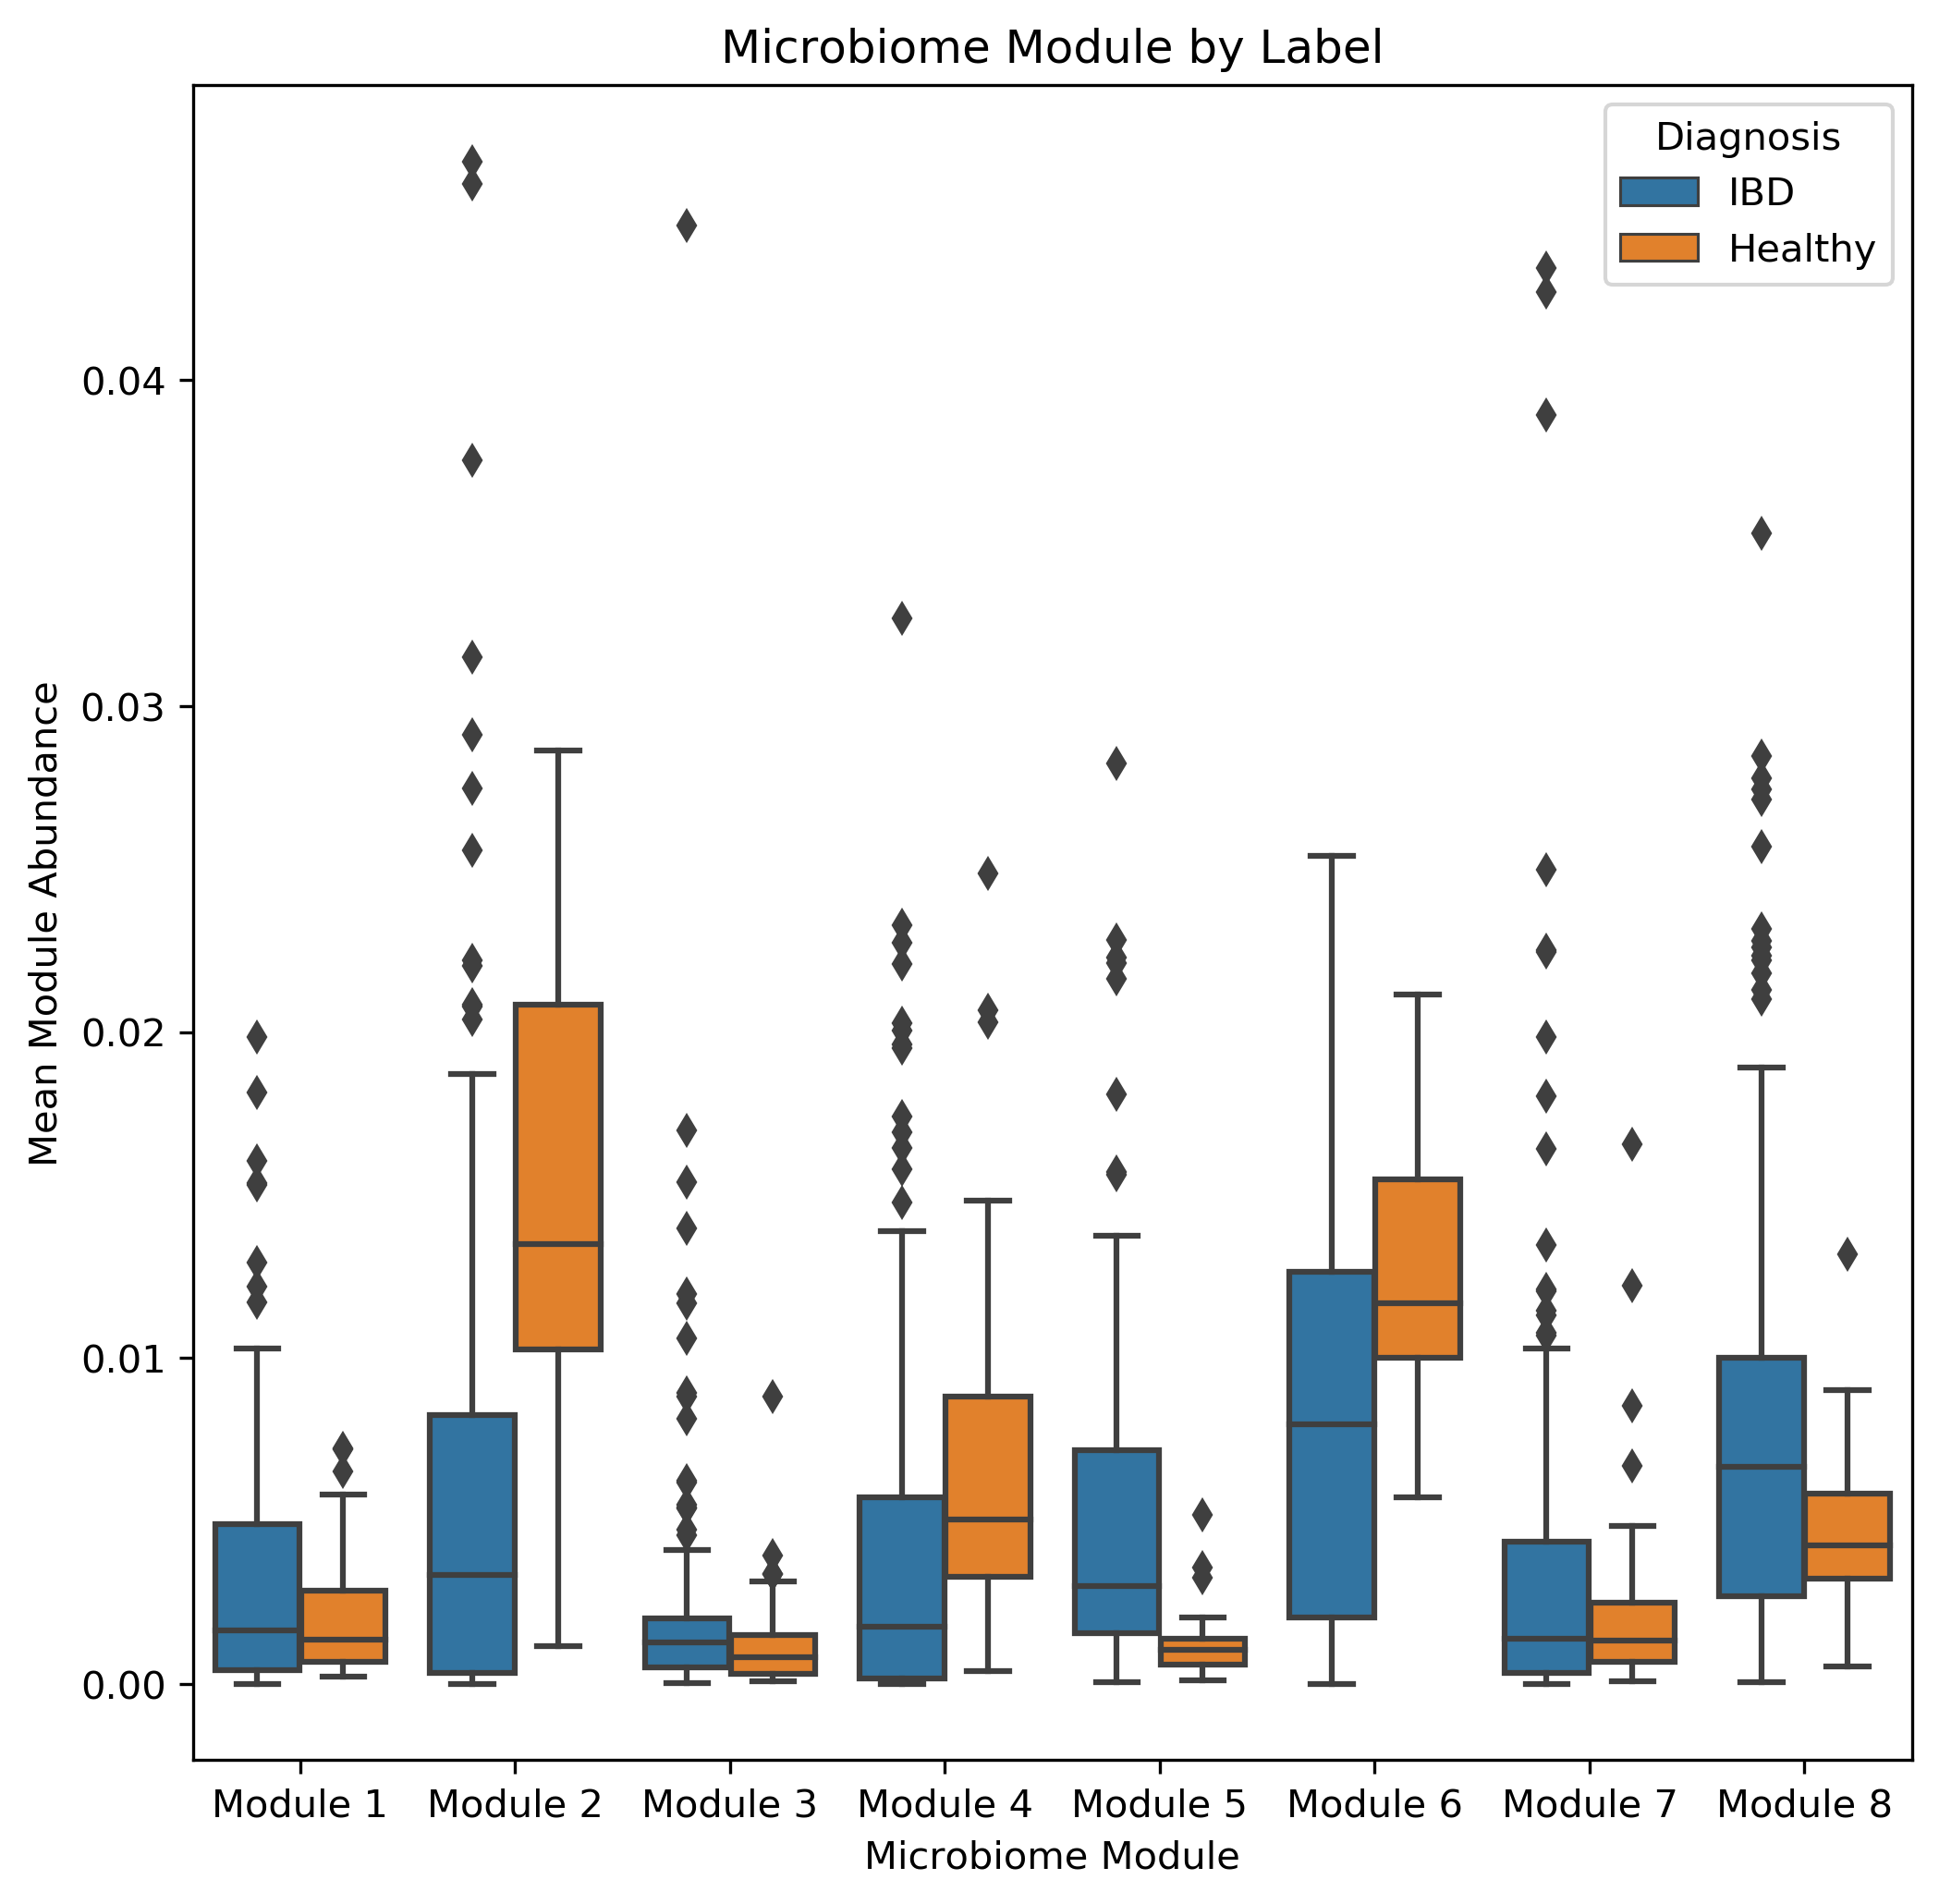

In [10]:
diagnosis = pd.read_csv("data/IBD/diagnosis.csv", index_col=0).loc[samples].values

labels = np.unique(diagnosis)
g0 = samples[(diagnosis==labels[0]).reshape(-1)]
g1 = samples[(diagnosis==labels[1]).reshape(-1)]

micro_sub = micro_comp_df
enriched_in = []
p_list = []

micro_comp_cluster_df = pd.DataFrame(index=samples)

micro_sub = pd.DataFrame(index=micro_sub.index, columns=micro_sub.columns,
                         data = micro_sub)
microbe_clusters = pd.read_csv("results/IBD/microbe_clusters.csv", index_col=0)
num_microbiome_clusters = microbiome_clusters["Cluster"].max() + 1

for mc in range(num_microbiome_clusters):
    g0_cluster = micro_sub.loc[g0, microbe_clusters["Cluster"]==mc].mean(1).values
    g1_cluster =  micro_sub.loc[g1, microbe_clusters["Cluster"]==mc].mean(1).values
    micro_comp_cluster_df["Module " + str(mc + 1)] = micro_sub.loc[:,microbe_clusters["Cluster"]==mc].mean(1).values
    p_value = mannwhitneyu(g0_cluster, g1_cluster)[1]
    p_list.append(p_value)
    if p_value < 0.05:
        p_value_one_sided = mannwhitneyu(g0_cluster, g1_cluster, alternative="greater")[1]
        if p_value_one_sided < 0.05:
            enriched_in.append(labels[0])
        else:
            enriched_in.append(labels[1])
    else:
        enriched_in.append("None")
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
import matplotlib
matplotlib.rc('font', **font)     
micro_cluster_enrichment_df = pd.DataFrame(index=["Microbial Module " + str(x) for x in range(num_microbiome_clusters)])
micro_cluster_enrichment_df["p-value"] = p_list
micro_cluster_enrichment_df["Enriched"] = enriched_in
micro_comp_cluster_df["Diagnosis"] = diagnosis
print(micro_cluster_enrichment_df)
micro_box_df = pd.melt(micro_comp_cluster_df, id_vars= ["Diagnosis"], value_vars=micro_comp_cluster_df.columns[0:num_microbiome_clusters])
plt.figure(figsize=(8,8), dpi=300)
sns.boxplot(data=micro_box_df, x="variable", y="value", hue="Diagnosis")
plt.xlabel("Microbiome Module")
plt.ylabel("Mean Module Abundance")
plt.title("Microbiome Module by Label")
plt.savefig("results/IBD/Images/micro_module_enrichment.png")

                          p-value Enriched
Metabolite Module 0  6.392771e-08      IBD
Metabolite Module 1  1.323376e-09  Healthy
Metabolite Module 2  2.547685e-09  Healthy
Metabolite Module 3  2.339137e-05      IBD
Metabolite Module 4  8.841909e-11      IBD
Metabolite Module 5  2.357738e-01     None
Metabolite Module 6  3.418024e-03  Healthy
Metabolite Module 7  4.363475e-03  Healthy


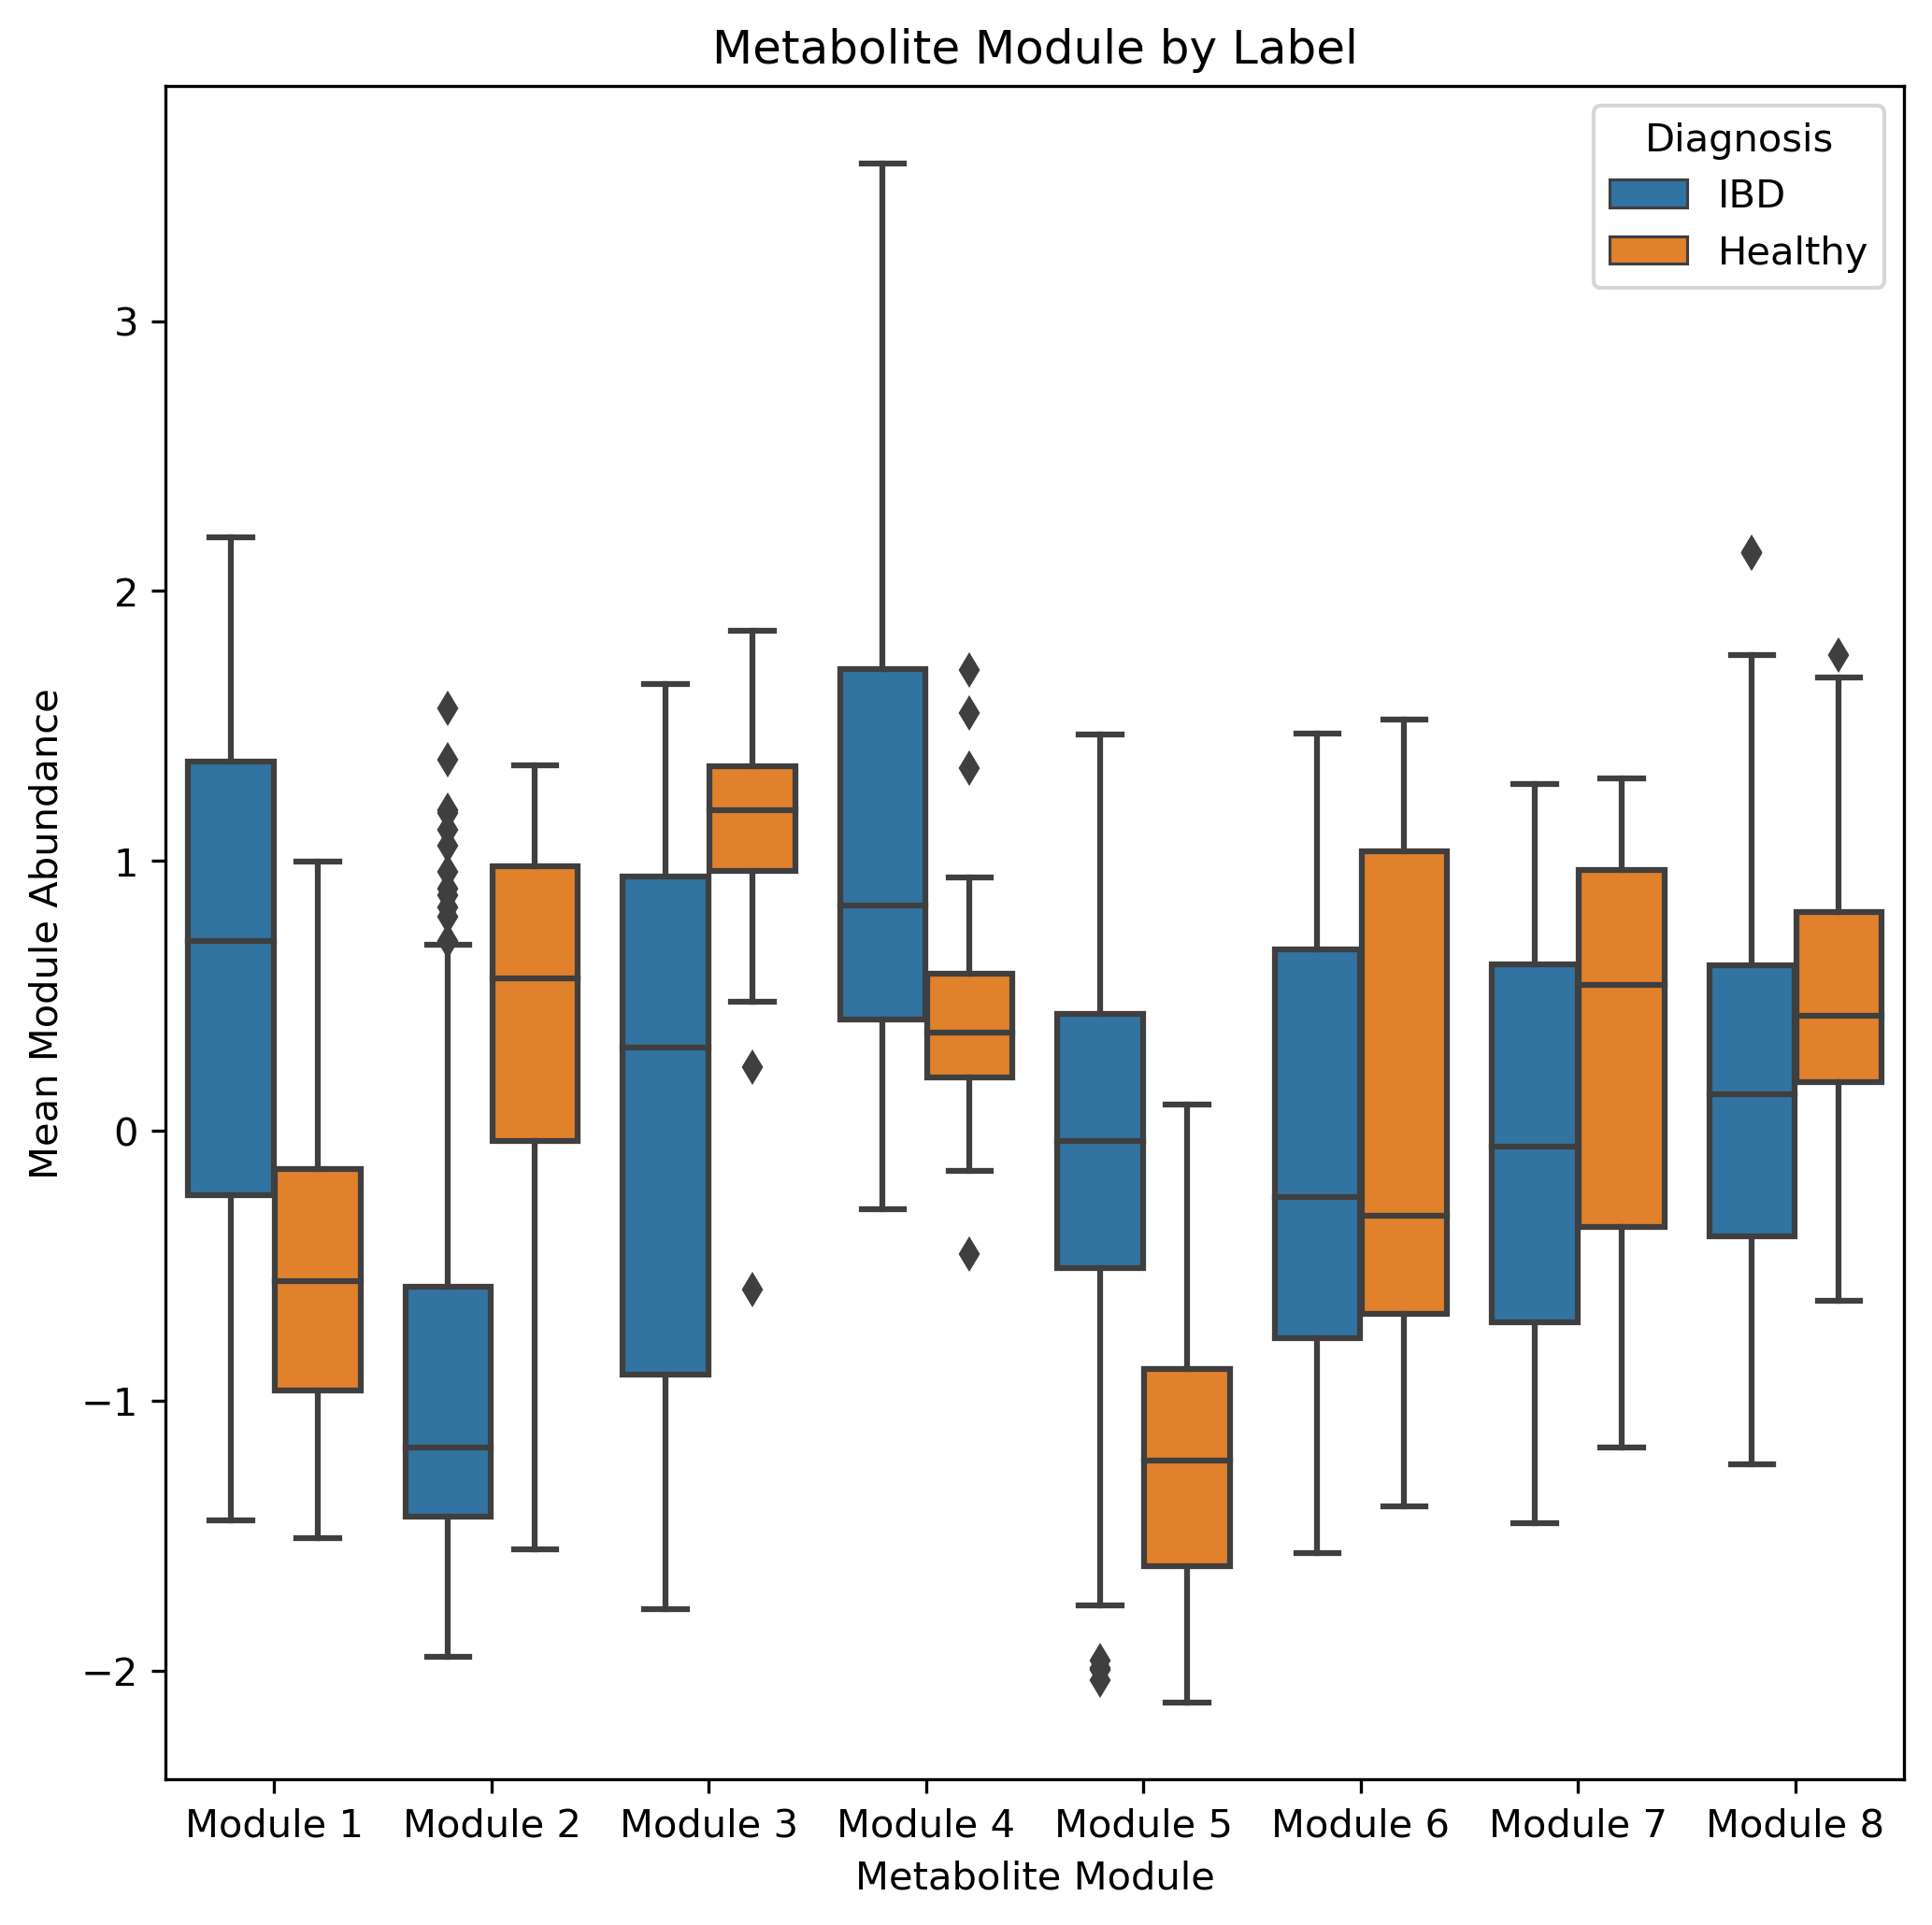

In [15]:
metab_sub = metab_comp_df
enriched_in = []
p_list = []

metab_comp_cluster_df = pd.DataFrame(index=samples)
metab_sub = pd.DataFrame(index=metab_sub.index, columns=metab_sub.columns,
                         data = metab_sub)
metabolite_clusters = pd.read_csv("results/IBD/metabolite_clusters.csv", index_col=0)
metab_sub = metab_sub[metabolite_clusters.index]
num_metabolite_clusters = metaboltie_clusters["Cluster"].max() + 1

for mc in range(num_metabolite_clusters):
    g0_cluster = metab_sub.loc[g0, metabolite_clusters["Cluster"]==mc].mean(1).values
    g1_cluster =  metab_sub.loc[g1, metabolite_clusters["Cluster"]==mc].mean(1).values
    metab_comp_cluster_df["Module " + str(mc + 1)] = metab_sub.loc[:,metabolite_clusters["Cluster"]==mc].mean(1).values
    p_value = mannwhitneyu(g0_cluster, g1_cluster)[1]
    p_list.append(p_value)
    if p_value < 0.05:
        p_value_one_sided = mannwhitneyu(g0_cluster, g1_cluster, alternative="greater")[1]
        if p_value_one_sided < 0.05:
            enriched_in.append(labels[0])
        else:
            enriched_in.append(labels[1])
    else:
        enriched_in.append("None")
                

metab_cluster_enrichment_df = pd.DataFrame(index=["Metabolite Module " + str(x) for x in range(num_metabolite_clusters)])
metab_cluster_enrichment_df["p-value"] = p_list
metab_cluster_enrichment_df["Enriched"] = enriched_in

metab_comp_cluster_df["Diagnosis"] = diagnosis
print(metab_cluster_enrichment_df)
metab_cluster_enrichment_df.to_csv("results/IBD/metabolite_cluster_enrichment.csv")
metab_box_df = pd.melt(metab_comp_cluster_df, id_vars= ["Diagnosis"], value_vars=metab_comp_cluster_df.columns[0:num_metabolite_clusters])
plt.figure(figsize=(8,8), dpi=300)
sns.boxplot(data=metab_box_df, x="variable", y="value", hue="Diagnosis")
plt.xlabel("Metabolite Module")
plt.ylabel("Mean Module Abundance")
plt.title("Metabolite Module by Label")
plt.savefig("results/IBD/Images/metab_module_enrichment.png")

### Generate Network JSON File for Cytoscape Use

In [ ]:
network = {}
network["elements"] = {}
network["elements"]["nodes"] = []
network["elements"]["edges"] = []

for s in range(num_metabolite_clusters):
    node = {"data": {'id': "Metabolic_" + str (s)}}
    network["elements"]["nodes"].append(node)
    
for s in range(num_microbiome_clusters):
    node = {"data": {'id': "Microbiome_" + str(s)}}
    network["elements"]["nodes"].append(node)
score_list = []

for mic in range(num_microbiome_clusters):
    print("\n\n")
    for met in range(num_metabolite_clusters):
        score = np.round(np.mean(binary_score_df.values[microbe_clusters==mic,:][:,metabolite_clusters==met].flatten()),3)
        edge = {"data": {"id": "Micro_" + str(mic) + "_to_Metab_" + str(met), "source":"Microbiome_" + str(mic), "target":"Metabolic_" + str(met), "score":score}}
        network["elements"]["edges"].append(edge)
        score_list.append(score)
with open('./results/IBD/CV/network.json', 'w') as outfile:
    json.dump(network, outfile)

### Evaluation of External Dataset

In [ ]:
# Set up output directory for training on full dataset
dirName = 'results/IBD/Full'
    
try:
    os.mkdir(dirName)
except FileExistsError:
    pass
              
microbe_cluster_matrix_list = []
metabolite_cluster_matrix_list = []

for run in range(0,num_run):

    # Set up output directory for training on full dataset
    dirName = 'results/IBD/Full/' + str(run) 
    
    try:
        os.mkdir(dirName)
    except FileExistsError:
        pass
                
    train_micro = micro_comp_df
    train_metab = metab_comp_df
    
    # Log transform data if RA
    train_micro = np.log(train_micro + 1)            
                
    # Scale data before neural network training
    micro_scaler = StandardScaler().fit(train_micro)
    train_micro = micro_scaler.transform(train_micro)
                
    metab_scaler = StandardScaler().fit(train_metab)
    train_metab = metab_scaler.transform(train_metab)

    # Aggregate paired microbiome and metabolomic data
    train = (train_micro, train_metab)

    print("Run: %02d" % (run + 1), end="\r")
                
    # Construct Neural Network Model
    model = MiMeNet(train_micro.shape[1], train_metab.shape[1], l1=l1, l2=l2, 
                        num_layer=num_layer, layer_nodes=layer_nodes, dropout=dropout)

    #Train Neural Network Model
    model.train(train)
          
    score_matrix_df = pd.DataFrame(data=model.get_scores(), index=micro_comp_df.columns, 
                                   columns=metab_comp_df.columns)
    score_matrix_df.to_csv(dirName + "/score_matrix.csv")
    
    reduced_score_df = score_matrix_df.loc[sig_microbes,sig_metabolites]
 
    clustmap = sns.clustermap(reduced_score_df.values, method="average", cmap="coolwarm")
    plt.clf()
    
    metabolite_tree = clustmap.dendrogram_col.linkage
    microbe_tree = clustmap.dendrogram_row.linkage

    metabolite_clusters = np.array(cut_tree(metabolite_tree, n_clusters=8)).reshape(-1)
    microbe_clusters = np.array(cut_tree(microbe_tree, n_clusters=6)).reshape(-1)
    
    col_pallete = sns.hls_palette(metab_clusters + micro_clusters, l=0.5, s=0.8)
    
    metab_col_scale = 1/(metab_clusters-1)
    micro_col_scale = 1/(micro_clusters-1)
    
    micro_colors = [(0.5,1-x*micro_col_scale,x*micro_col_scale) for x in microbe_clusters]
    metab_colors = [(1-x*metab_col_scale,0.5,x*metab_col_scale) for x in metabolite_clusters]
    
    sns.clustermap(reduced_score_df, method="complete", row_colors = micro_colors, col_colors=metab_colors,
                   cmap = "coolwarm", figsize=(8,8), cbar_pos=(0.05, 0.88, 0.025, 0.10), z_score=0)
    plt.savefig(dirName + "/clustermap.png", dpi=300)
    plt.clf()
    reduced_score_df.to_csv(dirName + "/interaction_score_matrix.csv")

    micro_cluster_matrix = np.zeros((reduced_score_df.values.shape[0], reduced_score_df.values.shape[0]))
    metab_cluster_matrix = np.zeros((reduced_score_df.values.shape[1], reduced_score_df.values.shape[1]))
    
    for m in range(0, len(microbe_clusters)):
        for n in range(m, len(microbe_clusters)):
            if microbe_clusters[m] == microbe_clusters[n]:
                micro_cluster_matrix[m,n] = 1
                micro_cluster_matrix[n,m] = 1

    for m in range(0, len(metabolite_clusters)):
        for n in range(m, len(metabolite_clusters)):
            if metabolite_clusters[m] == metabolite_clusters[n]:
                metab_cluster_matrix[m,n] = 1
                metab_cluster_matrix[n,m] = 1
                
    pd.DataFrame(data=micro_cluster_matrix, index=reduced_score_df.index, 
                 columns=reduced_score_df.index).to_csv(dirName + "/microbe_cluster_matrix.csv")   
    
    pd.DataFrame(data=metab_cluster_matrix, index=reduced_score_df.columns, 
                 columns=reduced_score_df.columns).to_csv(dirName + "/metabolite_cluster_matrix.csv")  
    
    microbe_cluster_matrix_list.append(micro_cluster_matrix)
    metabolite_cluster_matrix_list.append(metab_cluster_matrix)  
    model.model.save(dirName + "/network_model.h5")

    model.destroy()
    tf.keras.backend.clear_session()
    

consensus_list = []
micro_cluster_matrix_df = pd.read_csv("results/IBD/CV/microbe_cluster_matrix.csv", index_col=0)

for r in range(num_run):
    run_micro_cluster_matrix_df = pd.read_csv("results/IBD/Full/" + str(r) + "/microbe_cluster_matrix.csv", index_col=0)
    hits = np.sum(micro_cluster_matrix_df.values == run_micro_cluster_matrix_df.values)
    total = micro_cluster_matrix_df.values.shape[0] * micro_cluster_matrix_df.values.shape[1]
    consensus_list.append(hits/total)
    
print("Selecting Full Model %d with consensus %.2f" % (np.argmax(consensus_list), np.max(consensus_list)))

final_model = tf.keras.models.load_model("results/IBD/Full/" + str(np.argmax(consensus_list)) + "/network_model.h5")
final_model.save("results/IBD/final_network_model.h5")

test_micro = external_micro_comp_df
test_micro = np.log(test_micro + 1)
    
test_micro = micro_scaler.transform(test_micro)
pred = final_model.predict(test_micro)
inv_pred = metab_scaler.inverse_transform(pred)
      
external_pred_df = pd.DataFrame(data = inv_pred, index=external_samples, columns=external_metab_comp_df.columns)
external_pred_df.to_csv("results/IBD/external_predictions.csv")
    
external_corr = external_metab_comp_df.corrwith(external_pred_df, method="spearman")
print("External mean correlation %.2f" % (np.mean(external_corr)))
print("%d of %d metabolites are significantly correlated in external evaluation" % (sum(external_corr.values > cutoff_rho), 
                                                                                    len(external_corr.index.values)))  
       
external_sig_metabolites = annotated_metabolites[external_corr.loc[annotated_metabolites].values > cutoff_rho]
print("%d of %d annotated metabolites are significantly correlated in the external evaluation" % (len(external_sig_metabolites), 
                                                                                                  len(annotated_metabolites)))

In [ ]:
correlation_external_df = pd.DataFrame(index=metab_comp_df.columns)

for run in range(num_run):
    preds = pd.read_csv('results/IBD/External/' + str(run) +  "/prediction.tsv", sep="\t", index_col=0)
    y = external_metab_comp_df

    cor = y.corrwith(preds, method="spearman")
    correlation_external_df["Run_"+str(run)] = cor.loc[correlation_external_df.index]
    
correlation_external_df["Mean"] = correlation_external_df.mean(axis=1)
correlation_external_df = correlation_external_df.sort_values("Mean", ascending=False)
correlation_external_df.to_csv("results/IBD/External/correlations.tsv", sep="\t")
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(111)
sns.distplot(correlation_external_df["Mean"], bins=20)
sns.distplot(bg_corr, label="Background")
plt.axvline(x=cutoff_rho, color="red", lw=2, label="95% Cutoff")
plt.axvspan(cutoff_rho, 1.0, alpha=0.2, color='gray')
plt.xlim(-1,1)
plt.title("External IBD Prediction Correlation")
plt.ylabel("Frequency")
plt.xlabel("Spearman Correlation")
plt.text(0.1, 0.9,"Mean: %.3f"%correlation_external_df["Mean"].mean(),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
plt.savefig("results/IBD/External/correlations.png")
plt.show()

### Evaluation of Multitask Benefit

In [427]:
micro = micro_comp_df.values
metab = metab_comp_df.values

dirName = 'results/IBD/Noise/'

try:
    os.mkdir(dirName)
except FileExistsError:
    pass

for n in range(60,101):
    noise = n/10.0
    print("Noise: %.2f" % noise, end="\r")
    
    dirName = 'results/IBD/Noise/Noise_' + str(noise) 

    try:
        os.mkdir(dirName)
    except FileExistsError:
        pass

    for cv in range(num_cv):

        dirName = 'results/IBD/Noise/Noise_' + str(noise) + "/" + str(cv)
        try:
            os.mkdir(dirName)
        except FileExistsError:
            pass
        
        train_micro = pd.read_csv("results/IBD/CV/0/" + str(cv) + "/train_microbes.csv", index_col=0)
        test_micro = pd.read_csv("results/IBD/CV/0/" + str(cv) + "/test_microbes.csv", index_col=0)
        train_metab = pd.read_csv("results/IBD/CV/0/" + str(cv) + "/train_metabolites.csv", index_col=0)
        test_metab = pd.read_csv("results/IBD/CV/0/" + str(cv) + "/test_metabolites.csv", index_col=0)
            
        train_samples = train_micro.index
        test_samples = test_micro.index
        train_micro = np.log(train_micro + 1)
        test_micro = np.log(test_micro + 1)
            
        micro_scaler = StandardScaler().fit(train_micro)
        train_micro = micro_scaler.transform(train_micro)
        test_micro = micro_scaler.transform(test_micro)       
        train_metab[metabolome_meta_df.index.values] += np.random.normal(0,noise,train_metab[metabolome_meta_df.index.values].values.shape)
   
        train_metab_sub = train_metab[metabolome_meta_df.index.values]   
        test_metab_sub = test_metab[metabolome_meta_df.index.values]        
        
        metab_scaler = StandardScaler().fit(train_metab)
        train_metab = metab_scaler.transform(train_metab)
        test_metab = metab_scaler.transform(test_metab)            

        metab_scaler_sub = StandardScaler().fit(train_metab_sub)
        train_metab_sub = metab_scaler_sub.transform(train_metab_sub)
        test_metab_sub = metab_scaler_sub.transform(test_metab_sub)            



        train = (train_micro, train_metab)
        train_sub = (train_micro, train_metab_sub)
            
        test = (test_micro, test_metab)
        test_sub = (test_micro, test_metab_sub)

            
        model = MiMeNet(train_micro.shape[1], train_metab.shape[1], l1=l1, l2=l2, 
                    num_layer=num_layer, layer_nodes=layer_nodes, dropout=dropout)
        model_sub = MiMeNet(train_micro.shape[1], train_metab_sub.shape[1], l1=l1, l2=l2, 
                    num_layer=num_layer, layer_nodes=layer_nodes, dropout=dropout)
            
        model.train(train)
        model_sub.train(train_sub)
            
        p = model.test(test)
        inv_p = metab_scaler.inverse_transform(p)
        prediction_df = pd.DataFrame(data=inv_p, index=test_samples, columns=metab_comp_df.columns)
        prediction_df.to_csv(dirName + "/noise_prediction.csv")
        
        p = model_sub.test(test_sub)
        inv_p = metab_scaler_sub.inverse_transform(p)
        prediction_df = pd.DataFrame(data=inv_p, index=test_samples, columns=metab_comp_df[metabolome_meta_df.index].columns)
        prediction_df.to_csv(dirName + "/sub_noise_prediction.csv")  
        
        model.destroy()
        model_sub.destroy()
        tf.keras.backend.clear_session()


### Mean Correlation as Noise Increases

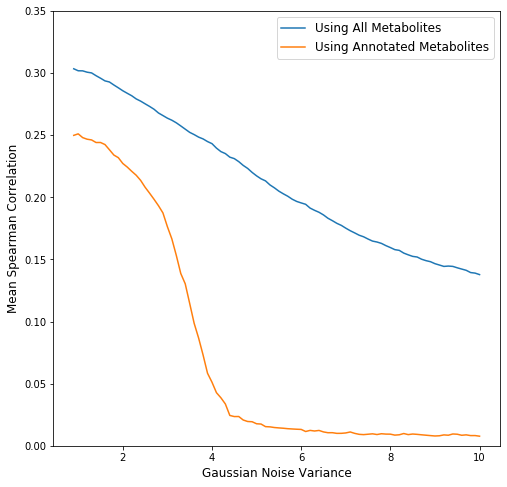

In [438]:
correlation_cv_noise_df = pd.DataFrame(index=metab_comp_df.columns)
correlation_cv_noise_sub_df = pd.DataFrame(index=metab_comp_df[metabolome_meta_df.index].columns)

y = pd.concat([pd.read_csv('results/IBD/CV/0/' + str(cv) + "/test_metabolites.csv", 
                            index_col=0) for cv in range(0, num_cv)])
for n in range(0,101):
    noise = n/10.0
    preds = pd.concat([pd.read_csv('results/IBD/Noise/Noise_' + str(noise) + '/' + str(cv) + "/noise_prediction.csv", 
                                    index_col=0) for cv in range(0, num_cv)])
    preds_sub = pd.concat([pd.read_csv('results/IBD/Noise/Noise_' + str(noise) + '/' + str(cv) + "/sub_noise_prediction.csv", 
                                    index_col=0) for cv in range(0, num_cv)])
    
    cor = y[metabolome_meta_df.index].corrwith(preds, method="spearman")
    correlation_cv_noise_df["Noise_"+str(noise)] = cor.loc[correlation_cv_noise_df.index]

    cor = y[metabolome_meta_df.index].corrwith(preds_sub, method="spearman")
    correlation_cv_noise_sub_df["Noise_"+str(noise)] = cor.loc[correlation_cv_noise_sub_df.index]    
    
plot_df = pd.DataFrame(data=[x/10.0 for x in range(0,101)], columns=["Gaussian Noise"])
plot_df["Using All Metabolites"] = correlation_cv_noise_df.mean(axis=0).values
plot_df["Using Annotated Metabolites"] = correlation_cv_noise_sub_df.mean(axis=0).values
rolling_plot_df = plot_df.rolling(10, on='Gaussian Noise').mean()

rolling_plot_df.plot(x="Gaussian Noise", figsize=(8,8))
plt.legend(fontsize=12)
plt.xlabel("Gaussian Noise Variance", fontsize=12)
plt.ylabel("Mean Spearman Correlation", fontsize=12)
plt.ylim(0,0.35)
plt.show()

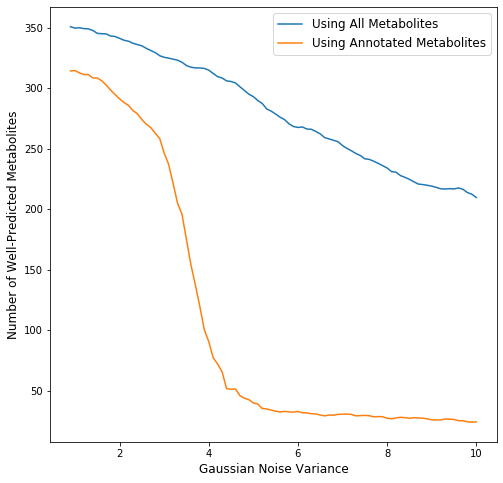

In [439]:
sig_noise = []
for c in correlation_cv_noise_df.columns:
    sig_noise.append(sum(correlation_cv_noise_df[c] > cutoff_rho))
    
sig_noise_sub = []
for c in correlation_cv_noise_sub_df.columns:
    sig_noise_sub.append(sum(correlation_cv_noise_sub_df[c] > cutoff_rho))
    

plot_df = pd.DataFrame(data=[x/10.0 for x in range(0,101)], columns=["Gaussian Noise"])
plot_df["Using All Metabolites"] = sig_noise
plot_df["Using Annotated Metabolites"] = sig_noise_sub
rolling_plot_df = plot_df.rolling(10, on='Gaussian Noise').mean()

rolling_plot_df.plot(x="Gaussian Noise", figsize=(8,8))
plt.legend(fontsize=12)
plt.xlabel("Gaussian Noise Variance", fontsize=12)
plt.ylabel("Number of Well-Predicted Metabolites", fontsize=12)
plt.show()

In [386]:
num_run_cv = 10
num_cv = 10

for run in range(0,num_run_cv):

    for cv in range(0, num_cv):

        train_micro = pd.read_csv("results/IBD/CV/" + str(run) + "/" + str(cv) + "/train_microbes.csv", index_col=0)
        test_micro = pd.read_csv("results/IBD/CV/" + str(run) + "/" + str(cv) + "/test_microbes.csv", index_col=0)
        train_metab = pd.read_csv("results/IBD/CV/" + str(run) + "/" + str(cv) + "/train_metabolites.csv", index_col=0)
        test_metab = pd.read_csv("results/IBD/CV/" + str(run) + "/" + str(cv) + "/test_metabolites.csv", index_col=0)
        train_samples = train_micro.index
        test_samples = test_micro.index
        
        # Log transform data if RA
        train_micro = np.log(train_micro + 1)
        test_micro = np.log(test_micro + 1)
                  
        train_metab = train_metab[metabolome_meta_df.index]
        test_metab = test_metab[metabolome_meta_df.index]
        
        # Scale data before neural network training
        micro_scaler = StandardScaler().fit(train_micro)
        train_micro = micro_scaler.transform(train_micro)
        test_micro = micro_scaler.transform(test_micro)       
                
        metab_scaler = StandardScaler().fit(train_metab)
        train_metab = metab_scaler.transform(train_metab)
        test_metab = metab_scaler.transform(test_metab)            

        # Aggregate paired microbiome and metabolomic data
        train = (train_micro, train_metab)
        test = (test_micro, test_metab)
                           
        print("Run: %02d\t\tFold: %02d" % (run + 1, cv + 1), end="\r")
                
        # Construct Neural Network Model
        model = MiMeNet(train_micro.shape[1], train_metab.shape[1], l1=l1, l2=l2, 
                            num_layer=num_layer, layer_nodes=layer_nodes, dropout=dropout)

        #Train Neural Network Model
        model.train(train)
                
        # Predict on test set
        p = model.test(test)

        inv_p = metab_scaler.inverse_transform(p)
                
        prediction_df = pd.DataFrame(data=inv_p, index=test_samples, columns=metab_comp_df[metabolome_meta_df.index].columns)
        prediction_df.to_csv("results/IBD/CV/" + str(run) + "/" + str(cv) + "/sub_prediction.csv")

        model.destroy()
        tf.keras.backend.clear_session()

        cv += 1
 

In [ ]:
print("\nCalculating correlations for cross-validated evaluation...")
          
correlation_cv_sub_df = pd.DataFrame(index=metab_comp_df[metabolome_meta_df.index].columns)

for run in range(num_run_cv):
    preds = pd.concat([pd.read_csv('results/IBD/CV/' + str(run)+ '/' + str(cv) + "/sub_prediction.csv", 
                                    index_col=0) for cv in range(0, num_cv)])
    y = pd.concat([pd.read_csv('results/IBD/CV/' + str(run)+ '/' + str(cv) + "/test_metabolites.csv", 
                                index_col=0) for cv in range(0, num_cv)])

    cor = y[metabolome_meta_df.index].corrwith(preds, method="spearman")
    correlation_cv_sub_df["Run_"+str(run)] = cor.loc[correlation_cv_sub_df.index]

correlation_cv_sub_df["Mean"] = correlation_cv_sub_df.mean(axis=1)
correlation_cv_sub_df = correlation_cv_sub_df.sort_values("Mean", ascending=False)
correlation_cv_sub_df.to_csv('results/IBD/cv_sub_correlations.csv')                                                        len(correlation_cv_sub_df["Mean"].values)))
    

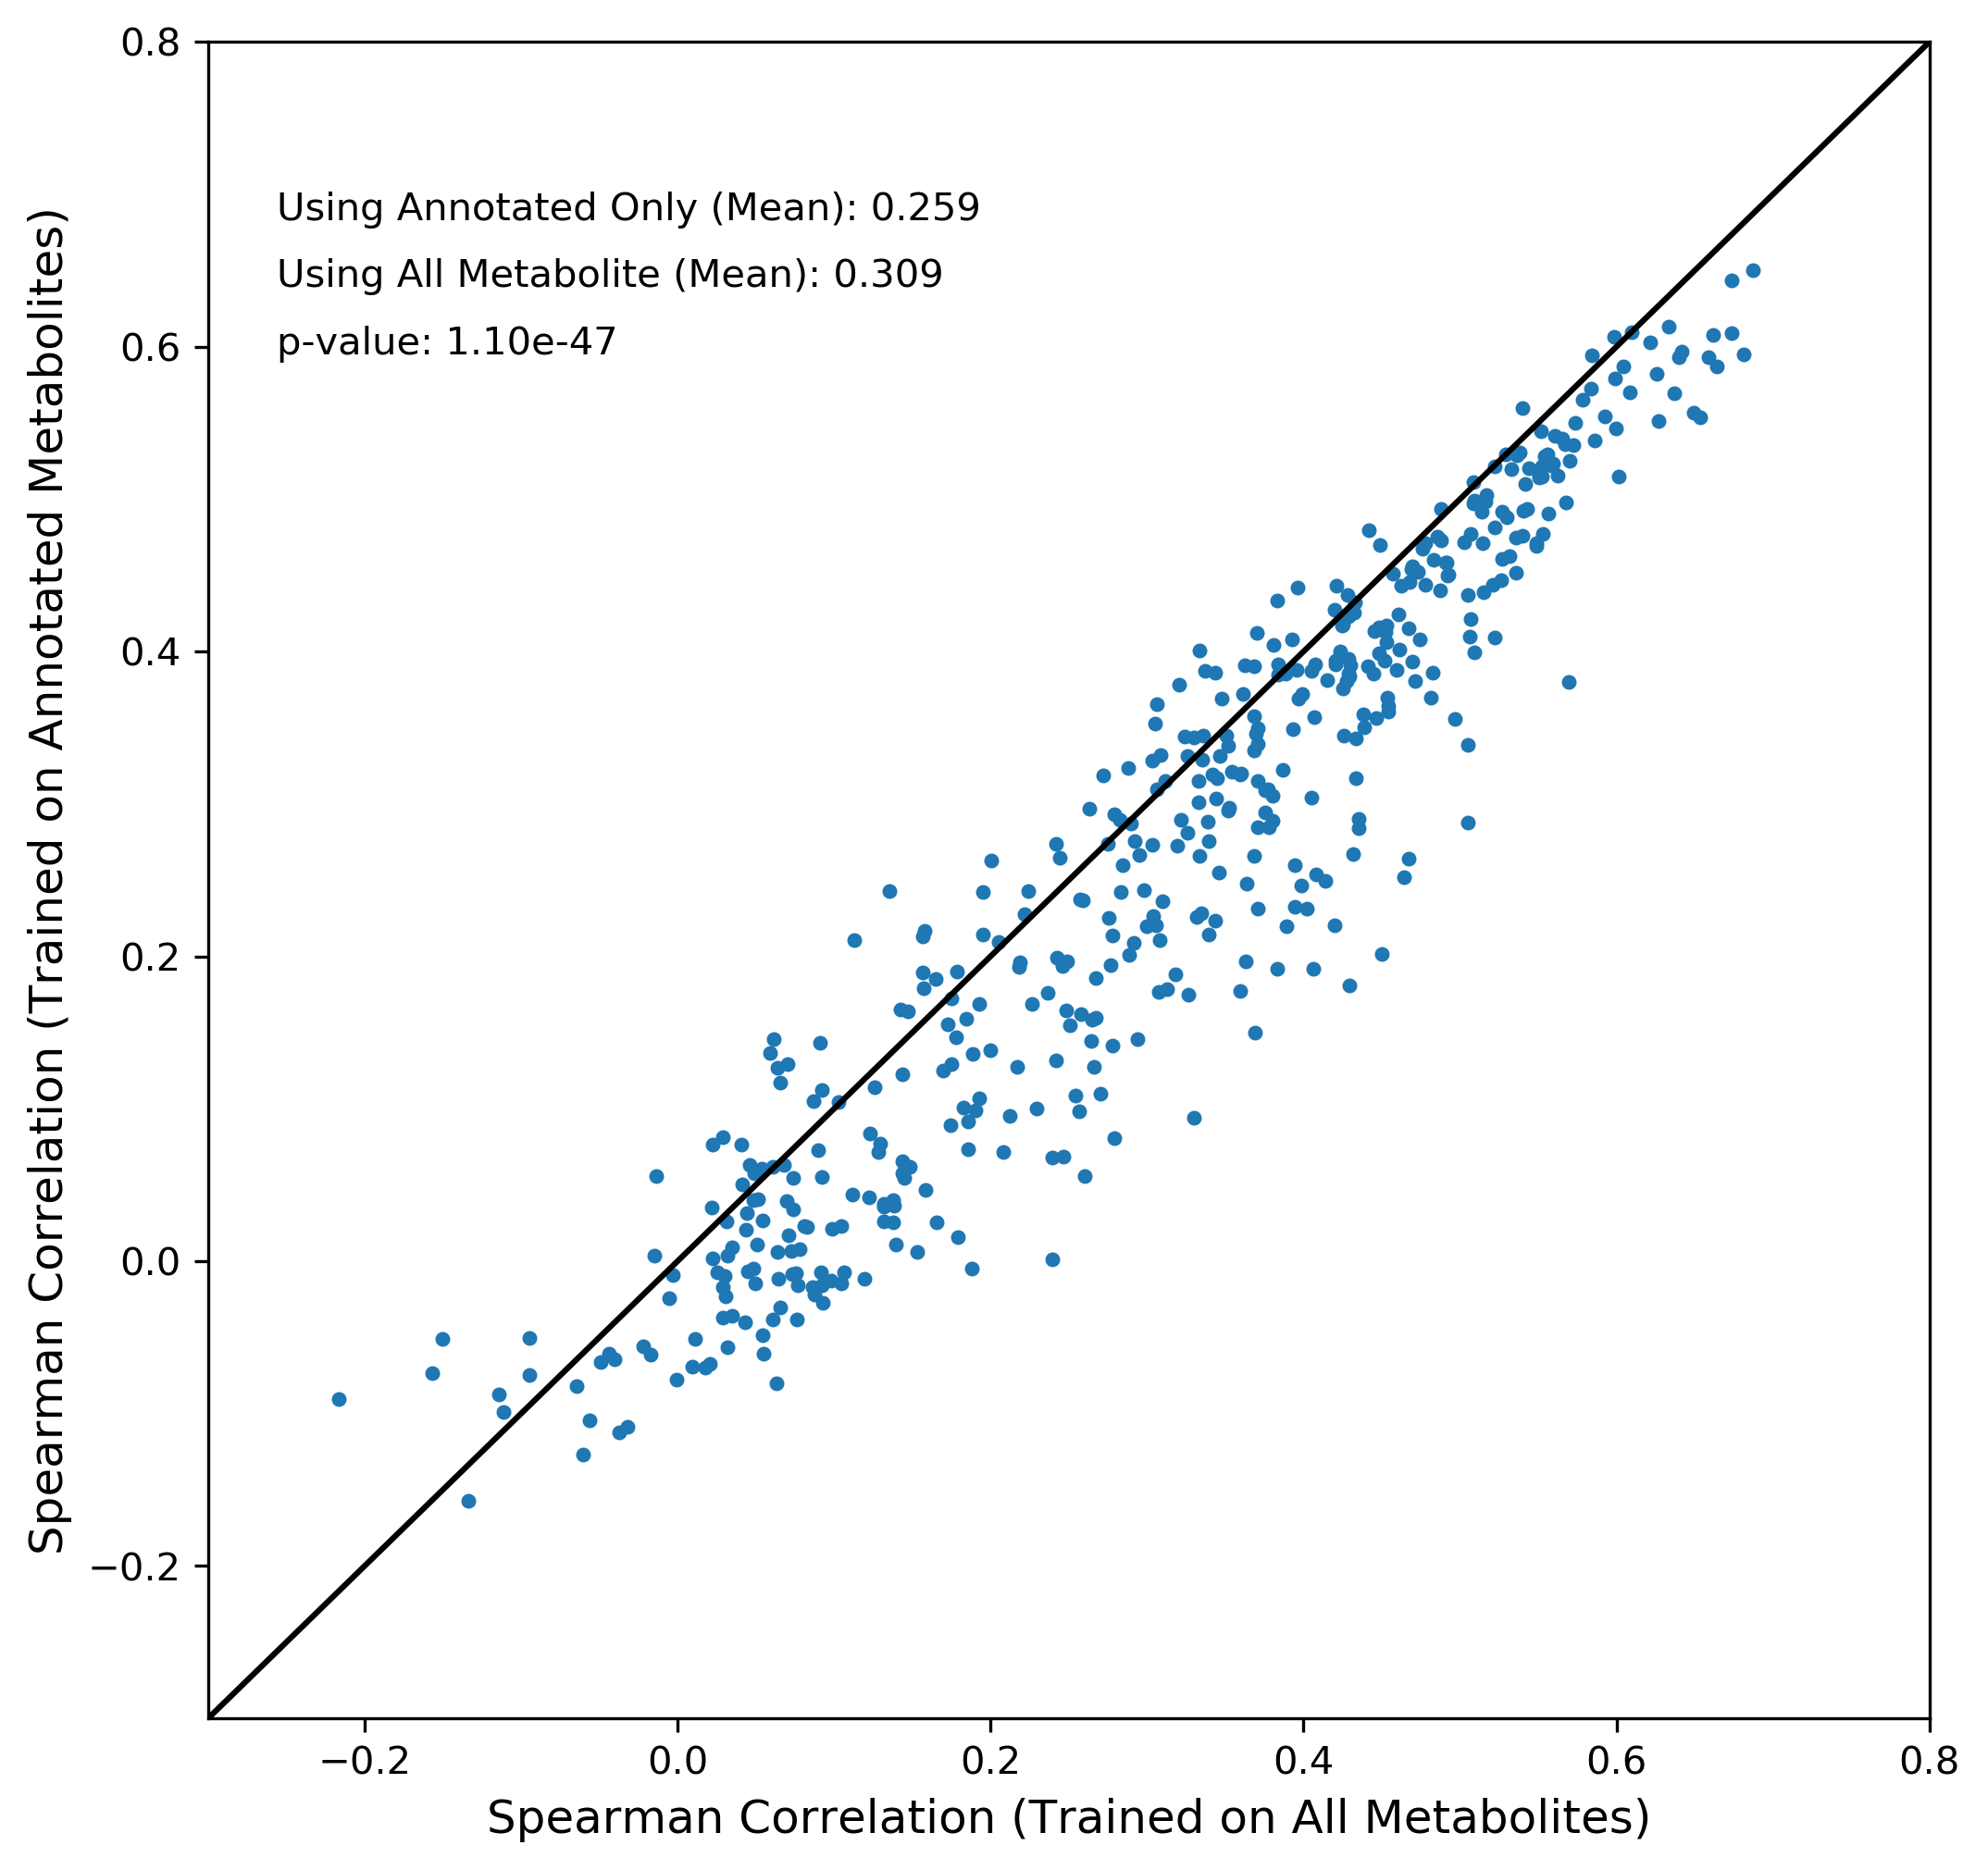

In [388]:
from scipy.stats import wilcoxon

fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(111)

full_corr = correlation_cv_df.loc[correlation_cv_sub_df.index]["Mean"]
sub_corr = correlation_cv_sub_df["Mean"]

p_value = wilcoxon(full_corr, sub_corr, alternative="greater")[1]

plt.scatter(full_corr, sub_corr, s=8)
plt.plot([-1,1],[-1,1], color="black")
#plt.plot([-1,cutoff_rho],[cutoff_rho,cutoff_rho], color="red")
#plt.plot([cutoff_rho,cutoff_rho],[cutoff_rho,-1], color="red")

plt.xlim(0,1)
plt.ylim(0,1)

plt.xlim(-0.3,0.8)
plt.ylim(-0.3,0.8)

plt.text(0.04, 0.9,"Using Annotated Only (Mean): %.3f"%np.mean(sub_corr),
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(0.04, 0.86,"Using All Metabolite (Mean): %.3f"%np.mean(full_corr),
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)

plt.text(0.04, 0.82,"p-value: %.2e"%p_value,
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)

plt.xlabel("Spearman Correlation (Trained on All Metabolites)", fontsize=12)
plt.ylabel("Spearman Correlation (Trained on Annotated Metabolites)", fontsize=12)
plt.savefig("results/IBD/Images/IBD_vs_IBD_sub_correlations.png")
